## Bayesian parameter estimation using MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots

## Probability model

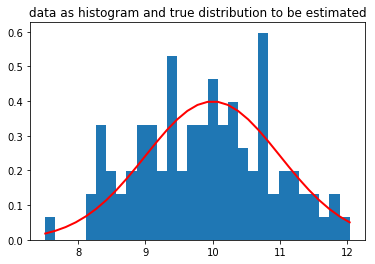

In [2]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [3]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal', 
                        prior_name = ['uniform','inv_gamma'], prior_params = [[0, 15], [1, 0, 1]], 
                        prior_type='marginal_pdf')

In [4]:
# Learn the unknown parameters using MCMC
bayes_estimator = BayesParameterEstimation(data=data, sampling_method = 'MCMC', nsamples=1000, 
                                           pdf_proposal_type = 'Normal', pdf_proposal_scale=1, model=candidate_model, 
                                           algorithm = 'MMH', jump=10, nburn=10, 
                                           seed=np.array([1.0, 0.2]))

UQpy: Running parameter estimation for candidate model: normal
Successful execution of the MCMC design
UQpy: Parameter estimation analysis completed!


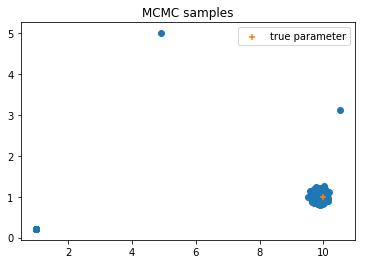

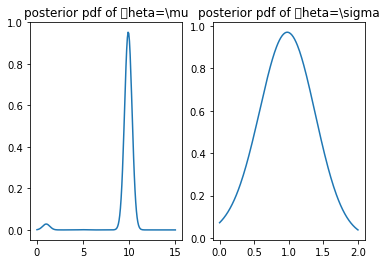

In [5]:
# print results
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(10, 1, marker = '+', label='true parameter')
plt.title('MCMC samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(0, 15, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,0].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[0].plot(domain, np.exp(log_dens))
ax[0].set_title('posterior pdf of \theta=\mu')

domain = np.linspace(0, 2, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,1].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[1].plot(domain, np.exp(log_dens))
ax[1].set_title('posterior pdf of \theta=\sigma')

plt.show()

## Regression model

In [6]:
# Generate data from a quadratic equation, add some noise to it
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_type='python', model_script='pfn_quadratic.py')

data = z.model_eval.QOI[0]+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)

Evaluating the model...

[  0.29220992  -0.67668305  -1.29017137   1.12009589   2.99366935
   3.03793605   4.38800557   4.70861925   4.91279772   9.41890397
  11.17917437  13.50215594  14.3018608   18.17903593  18.65068938
  21.10488936  26.53367124  27.71248665  31.15485992  34.53496429
  37.18728679  41.57712137  45.32350353  48.49198952  52.21652809
  58.5377634   61.52216605  66.43901703  70.09294115  77.30308365
  80.32308454  87.00890178  90.60810502  98.65855483 102.89644686
 108.05967417 115.70802752 122.2738239  127.65055746 134.63642777
 140.78929542 147.65720803 155.14867281 162.13854012 169.9977355
 178.41746052 187.41052675 193.38456214 198.50518709 208.10161519]


In [7]:
candidate_model = Model(model_type='python', model_script='pfn_quadratic.py', n_params=2, 
                        error_covariance=error_covariance)

In [8]:
bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, sampling_method = 'MCMC', nsamples=1000,
                                           algorithm = 'MMH', jump=10, nburn=500)

UQpy: Running parameter estimation for candidate model
Evaluating max likelihood estimate...
(1, 2)
[[0.3495436  0.91736784]]
[[0.36702078 0.91736784]]
[[0.3495436  0.96323623]]
[[0.36702078 0.96323623]]
[[0.37575937 0.98617043]]
[[0.35828219 1.03203882]]
[[0.3539129  1.08937431]]
[[0.38012867 1.1123085 ]]
[[0.3954212  1.18684464]]
[[0.37357472 1.29004852]]
[[0.3724824  1.44198757]]
[[0.4139907 1.5394579]]
[[0.44402961 1.7644997 ]]
[[0.42109081 2.01964263]]
[[0.43392561 2.43604163]]
[[0.49263801 2.34215476]]
[[0.46969921 2.59729769]]
[[0.45044701 1.9726992 ]]
[[0.3788998  1.65018707]]
[[0.46420346 2.16916284]]
[[0.40733435 1.82317899]]
[[0.44998618 2.08266688]]
[[0.42062998 2.12961031]]
[[0.42808424 2.09038253]]
[[0.45697962 2.15340678]]
[[0.43006301 2.05308367]]
[[0.45196495 2.04536801]]
[[0.43204178 2.01578481]]
[[0.44550008 2.06594636]]
[[0.42359814 2.07366201]]
[[0.43903521 2.08652471]]
[[0.43230606 2.06144393]]
[[0.454208   2.05372827]]
[[0.44655554 2.05871171]]
[[0.45974956 2.063

[[1.2045388  2.10005412]]
[[1.2045388  1.97237807]]
[[array([0.79725374]) 1.9723780723568103]]
[[1.2045388  1.97237807]]
[[1.2045388  1.50734826]]
[[1.2045388  1.97237807]]
[[array([1.66246263]) 1.9723780723568103]]
[[1.2045388  1.97237807]]
[[1.2045388  1.96831141]]
[[1.2045388  1.97237807]]
[[array([1.17578854]) 1.9683114064473168]]
[[1.2045388  1.96831141]]
[[1.2045388 1.6289314]]
[[1.2045388  1.96831141]]
[[array([1.67278191]) 1.9683114064473168]]
[[1.2045388  1.96831141]]
[[1.2045388  1.88392049]]
[[1.2045388  1.96831141]]
[[array([0.9801412]) 1.9683114064473168]]
[[1.2045388  1.96831141]]
[[1.2045388  1.82061125]]
[[1.2045388  1.96831141]]
[[array([1.56397502]) 1.9683114064473168]]
[[1.2045388  1.96831141]]
[[1.2045388  2.45818412]]
[[1.2045388  1.96831141]]
[[array([0.98412939]) 1.9683114064473168]]
[[1.2045388  1.96831141]]
[[1.2045388  1.61142207]]
[[1.2045388  1.96831141]]
[[array([1.62423103]) 1.9683114064473168]]
[[1.2045388  1.96831141]]
[[1.2045388  1.85248182]]
[[1.20453

[[1.19684139 1.96831141]]
[[1.19684139 2.09155809]]
[[1.19684139 1.96831141]]
[[array([1.13572378]) 1.9683114064473168]]
[[1.19684139 1.96831141]]
[[1.19684139 2.08745124]]
[[1.19684139 1.96831141]]
[[array([1.09199012]) 1.9683114064473168]]
[[1.19684139 1.96831141]]
[[1.19684139 2.3162691 ]]
[[1.19684139 1.96831141]]
[[array([1.09811894]) 1.9683114064473168]]
[[1.19684139 1.96831141]]
[[1.19684139 1.65909609]]
[[1.19684139 1.96831141]]
[[array([1.6061481]) 1.9683114064473168]]
[[1.19684139 1.96831141]]
[[1.19684139 2.25250097]]
[[1.19684139 1.96831141]]
[[array([0.83329325]) 1.9683114064473168]]
[[1.19684139 1.96831141]]
[[1.19684139 1.48648154]]
[[1.19684139 1.96831141]]
[[array([0.98242663]) 1.9683114064473168]]
[[1.19684139 1.96831141]]
[[1.19684139 1.91615015]]
[[1.19684139 1.96831141]]
[[array([1.63238061]) 1.9683114064473168]]
[[1.19684139 1.96831141]]
[[1.19684139 1.96538949]]
[[1.19684139 1.96831141]]
[[array([1.22075732]) 1.9683114064473168]]
[[1.19684139 1.96831141]]
[[1.220

[[1.24441365 1.51388321]]
[[1.24441365 1.96831141]]
[[array([1.13082084]) 1.9683114064473168]]
[[1.24441365 1.96831141]]
[[1.24441365 2.43793712]]
[[1.24441365 1.96831141]]
[[array([1.51705855]) 1.9683114064473168]]
[[1.24441365 1.96831141]]
[[1.24441365 2.26233084]]
[[1.24441365 1.96831141]]
[[array([1.40703178]) 1.9683114064473168]]
[[1.24441365 1.96831141]]
[[1.24441365 1.95148049]]
[[1.24441365 1.96831141]]
[[array([0.85110776]) 1.9683114064473168]]
[[1.24441365 1.96831141]]
[[1.24441365 1.79219658]]
[[1.24441365 1.96831141]]
[[array([0.9034092]) 1.9683114064473168]]
[[1.24441365 1.96831141]]
[[1.24441365 1.96106218]]
[[1.24441365 1.96831141]]
[[array([1.54931289]) 1.961062176916152]]
[[1.24441365 1.96106218]]
[[1.24441365 2.03509057]]
[[1.24441365 1.96106218]]
[[array([1.26061471]) 1.961062176916152]]
[[1.24441365 1.96106218]]
[[1.26061471 2.04672238]]
[[array([1.26061471]) 1.961062176916152]]
[[array([1.38219383]) 1.961062176916152]]
[[1.26061471 1.96106218]]
[[1.26061471 2.10599

[[array([0.82027974]) 1.9599841462083516]]
[[1.28447621 1.95998415]]
[[1.28447621 1.52588152]]
[[1.28447621 1.95998415]]
[[array([1.36716241]) 1.9599841462083516]]
[[1.28447621 1.95998415]]
[[1.28447621 2.1828134 ]]
[[1.28447621 1.95998415]]
[[array([0.98189053]) 1.9599841462083516]]
[[1.28447621 1.95998415]]
[[1.28447621 1.60069028]]
[[1.28447621 1.95998415]]
[[array([1.38457822]) 1.9599841462083516]]
[[1.28447621 1.95998415]]
[[1.28447621 2.22472964]]
[[1.28447621 1.95998415]]
[[array([1.03201979]) 1.9599841462083516]]
[[1.28447621 1.95998415]]
[[1.28447621 1.71836706]]
[[1.28447621 1.95998415]]
[[array([1.01384506]) 1.9599841462083516]]
[[1.28447621 1.95998415]]
[[1.28447621 2.12463139]]
[[1.28447621 1.95998415]]
[[array([0.925827]) 1.9599841462083516]]
[[1.28447621 1.95998415]]
[[1.28447621 1.5975177 ]]
[[1.28447621 1.95998415]]
[[array([1.1289759]) 1.9599841462083516]]
[[1.28447621 1.95998415]]
[[1.28447621 2.40307579]]
[[1.28447621 1.95998415]]
[[array([1.39149043]) 1.95998414620

[[array([0.87148104]) 1.9621275773681526]]
[[1.25564114 1.96212758]]
[[1.25564114 2.06129935]]
[[1.25564114 1.96212758]]
[[array([1.28050713]) 1.9621275773681526]]
[[1.25564114 1.96212758]]
[[1.28050713 2.03116472]]
[[array([1.28050713]) 1.9621275773681526]]
[[array([1.27061691]) 1.9621275773681526]]
[[1.28050713 1.96212758]]
[[1.27061691 1.95444596]]
[[array([1.27061691]) 1.9621275773681526]]
[[array([1.11326642]) 1.9621275773681526]]
[[1.27061691 1.96212758]]
[[1.27061691 1.90217563]]
[[1.27061691 1.96212758]]
[[array([1.73397098]) 1.9621275773681526]]
[[1.27061691 1.96212758]]
[[1.27061691 2.3039136 ]]
[[1.27061691 1.96212758]]
[[array([1.62475958]) 1.9621275773681526]]
[[1.27061691 1.96212758]]
[[1.27061691 1.61804201]]
[[1.27061691 1.96212758]]
[[array([1.54829057]) 1.9621275773681526]]
[[1.27061691 1.96212758]]
[[1.27061691 1.90542208]]
[[1.27061691 1.96212758]]
[[array([1.6400171]) 1.9621275773681526]]
[[1.27061691 1.96212758]]
[[1.27061691 1.85152164]]
[[1.27061691 1.96212758]]

[[1.23197085 1.52379403]]
[[1.23197085 1.96212758]]
[[array([1.34916736]) 1.9621275773681526]]
[[1.23197085 1.96212758]]
[[1.23197085 1.60278384]]
[[1.23197085 1.96212758]]
[[array([1.15900534]) 1.9621275773681526]]
[[1.23197085 1.96212758]]
[[1.23197085 2.02529049]]
[[1.23197085 1.96212758]]
[[array([1.14619942]) 1.9621275773681526]]
[[1.23197085 1.96212758]]
[[1.23197085 1.89376317]]
[[1.23197085 1.96212758]]
[[array([0.93679514]) 1.9621275773681526]]
[[1.23197085 1.96212758]]
[[1.23197085 1.46841714]]
[[1.23197085 1.96212758]]
[[array([1.2883114]) 1.9621275773681526]]
[[1.23197085 1.96212758]]
[[1.2883114  1.57851834]]
[[array([1.2883114]) 1.9621275773681526]]
[[array([1.29705488]) 1.9621275773681526]]
[[1.2883114  1.96212758]]
[[1.29705488 2.11094311]]
[[array([1.29705488]) 1.9621275773681526]]
[[array([1.33594227]) 1.9621275773681526]]
[[1.29705488 1.96212758]]
[[1.29705488 2.43888906]]
[[1.29705488 1.96212758]]
[[array([1.77083937]) 1.9621275773681526]]
[[1.29705488 1.96212758]]


[[1.2487383  1.96212758]]
[[1.26853956 1.55809974]]
[[array([1.26853956]) 1.9621275773681526]]
[[array([1.66920372]) 1.9621275773681526]]
[[1.26853956 1.96212758]]
[[1.26853956 1.85838451]]
[[1.26853956 1.96212758]]
[[array([1.57636766]) 1.9621275773681526]]
[[1.26853956 1.96212758]]
[[1.26853956 1.66358948]]
[[1.26853956 1.96212758]]
[[array([1.21691624]) 1.9621275773681526]]
[[1.26853956 1.96212758]]
[[1.26853956 1.63047628]]
[[1.26853956 1.96212758]]
[[array([1.31795346]) 1.9621275773681526]]
[[1.26853956 1.96212758]]
[[1.26853956 1.73036798]]
[[1.26853956 1.96212758]]
[[array([1.61133328]) 1.9621275773681526]]
[[1.26853956 1.96212758]]
[[1.26853956 2.10699514]]
[[1.26853956 1.96212758]]
[[array([0.83048333]) 1.9621275773681526]]
[[1.26853956 1.96212758]]
[[1.26853956 1.78158273]]
[[1.26853956 1.96212758]]
[[array([0.85973156]) 1.9621275773681526]]
[[1.26853956 1.96212758]]
[[1.26853956 2.24137782]]
[[1.26853956 1.96212758]]
[[array([1.298907]) 1.9621275773681526]]
[[1.26853956 1.96

[[array([0.92900454]) 1.9621275773681526]]
[[1.25172365 1.96212758]]
[[1.25172365 1.84179867]]
[[1.25172365 1.96212758]]
[[array([1.48721186]) 1.9621275773681526]]
[[1.25172365 1.96212758]]
[[1.25172365 1.54603078]]
[[1.25172365 1.96212758]]
[[array([0.94714509]) 1.9621275773681526]]
[[1.25172365 1.96212758]]
[[1.25172365 2.30154855]]
[[1.25172365 1.96212758]]
[[array([0.99429262]) 1.9621275773681526]]
[[1.25172365 1.96212758]]
[[1.25172365 1.99220619]]
[[1.25172365 1.96212758]]
[[array([0.83407175]) 1.9621275773681526]]
[[1.25172365 1.96212758]]
[[1.25172365 1.62255363]]
[[1.25172365 1.96212758]]
[[array([1.0835598]) 1.9621275773681526]]
[[1.25172365 1.96212758]]
[[1.25172365 1.92376988]]
[[1.25172365 1.96212758]]
[[array([1.69671435]) 1.9621275773681526]]
[[1.25172365 1.96212758]]
[[1.25172365 2.09100848]]
[[1.25172365 1.96212758]]
[[array([1.55641477]) 1.9621275773681526]]
[[1.25172365 1.96212758]]
[[1.25172365 2.459301  ]]
[[1.25172365 1.96212758]]
[[array([0.99490153]) 1.962127577

[[1.26888612 1.96212758]]
[[array([1.6779385]) 1.9621275773681526]]
[[1.26888612 1.96212758]]
[[1.26888612 1.96864625]]
[[1.26888612 1.96212758]]
[[array([1.12307338]) 1.9621275773681526]]
[[1.26888612 1.96212758]]
[[1.26888612 1.68454717]]
[[1.26888612 1.96212758]]
[[array([1.70459535]) 1.9621275773681526]]
[[1.26888612 1.96212758]]
[[1.26888612 1.86229126]]
[[1.26888612 1.96212758]]
[[array([1.22748171]) 1.9621275773681526]]
[[1.26888612 1.96212758]]
[[1.26888612 1.71174157]]
[[1.26888612 1.96212758]]
[[array([1.71180174]) 1.9621275773681526]]
[[1.26888612 1.96212758]]
[[1.26888612 1.59407486]]
[[1.26888612 1.96212758]]
[[array([1.20483251]) 1.9621275773681526]]
[[1.26888612 1.96212758]]
[[1.26888612 2.33496658]]
[[1.26888612 1.96212758]]
[[array([0.79283992]) 1.9621275773681526]]
[[1.26888612 1.96212758]]
[[1.26888612 1.79451295]]
[[1.26888612 1.96212758]]
[[array([1.12684081]) 1.9621275773681526]]
[[1.26888612 1.96212758]]
[[1.26888612 1.81678286]]
[[1.26888612 1.96212758]]
[[array

[[1.25138229 2.37847351]]
[[1.25138229 1.96212758]]
[[array([0.87452387]) 1.9621275773681526]]
[[1.25138229 1.96212758]]
[[1.25138229 2.16337947]]
[[1.25138229 1.96212758]]
[[array([1.03814497]) 1.9621275773681526]]
[[1.25138229 1.96212758]]
[[1.25138229 1.73234931]]
[[1.25138229 1.96212758]]
[[array([0.94063278]) 1.9621275773681526]]
[[1.25138229 1.96212758]]
[[1.25138229 2.02538299]]
[[1.25138229 1.96212758]]
[[array([1.04289244]) 1.9621275773681526]]
[[1.25138229 1.96212758]]
[[1.25138229 2.18759255]]
[[1.25138229 1.96212758]]
[[array([0.7950585]) 1.9621275773681526]]
[[1.25138229 1.96212758]]
[[1.25138229 1.85979333]]
[[1.25138229 1.96212758]]
[[array([1.23249786]) 1.9621275773681526]]
[[1.25138229 1.96212758]]
[[1.23249786 1.99815655]]
[[array([1.23249786]) 1.9621275773681526]]
[[array([1.37027688]) 1.9621275773681526]]
[[1.23249786 1.96212758]]
[[1.23249786 2.28647945]]
[[1.23249786 1.96212758]]
[[array([1.61414092]) 1.9621275773681526]]
[[1.23249786 1.96212758]]
[[1.23249786 1.4

[[1.2652275  1.55465481]]
[[1.2652275  1.95996593]]
[[array([0.86233736]) 1.9599659253554678]]
[[1.2652275  1.95996593]]
[[1.2652275  2.04014341]]
[[1.2652275  1.95996593]]
[[array([1.61828459]) 1.9599659253554678]]
[[1.2652275  1.95996593]]
[[1.2652275  1.92729933]]
[[1.2652275  1.95996593]]
[[array([0.82645531]) 1.9599659253554678]]
[[1.2652275  1.95996593]]
[[1.2652275 1.5305991]]
[[1.2652275  1.95996593]]
[[array([0.88618278]) 1.9599659253554678]]
[[1.2652275  1.95996593]]
[[1.2652275  2.40870715]]
[[1.2652275  1.95996593]]
[[array([0.94718186]) 1.9599659253554678]]
[[1.2652275  1.95996593]]
[[1.2652275  2.28399445]]
[[1.2652275  1.95996593]]
[[array([0.9137344]) 1.9599659253554678]]
[[1.2652275  1.95996593]]
[[1.2652275  1.73582026]]
[[1.2652275  1.95996593]]
[[array([1.32657438]) 1.9599659253554678]]
[[1.2652275  1.95996593]]
[[1.2652275  1.70116377]]
[[1.2652275  1.95996593]]
[[array([0.93262693]) 1.9599659253554678]]
[[1.2652275  1.95996593]]
[[1.2652275  2.26224564]]
[[1.26522

[[1.20579885 1.81718215]]
[[1.20579885 1.96773411]]
[[array([0.8908206]) 1.9677341051246415]]
[[1.20579885 1.96773411]]
[[1.20579885 1.82275379]]
[[1.20579885 1.96773411]]
[[array([1.38766082]) 1.9677341051246415]]
[[1.20579885 1.96773411]]
[[1.20579885 2.18617914]]
[[1.20579885 1.96773411]]
[[array([1.38609819]) 1.9677341051246415]]
[[1.20579885 1.96773411]]
[[1.20579885 2.03267375]]
[[1.20579885 1.96773411]]
[[array([0.93044425]) 1.9677341051246415]]
[[1.20579885 1.96773411]]
[[1.20579885 1.59015724]]
[[1.20579885 1.96773411]]
[[array([1.59535302]) 1.9677341051246415]]
[[1.20579885 1.96773411]]
[[1.20579885 1.87922674]]
[[1.20579885 1.96773411]]
[[array([0.70898061]) 1.9677341051246415]]
[[1.20579885 1.96773411]]
[[1.20579885 1.58142308]]
[[1.20579885 1.96773411]]
[[array([0.96533456]) 1.9677341051246415]]
[[1.20579885 1.96773411]]
[[1.20579885 1.75641762]]
[[1.20579885 1.96773411]]
[[array([1.00326612]) 1.9677341051246415]]
[[1.20579885 1.96773411]]
[[1.20579885 2.14258791]]
[[1.205

[[array([0.99433414]) 1.9746294824584023]]
[[1.12916631 1.97462948]]
[[1.12916631 1.57271525]]
[[1.12916631 1.97462948]]
[[array([1.40516814]) 1.9746294824584023]]
[[1.12916631 1.97462948]]
[[1.12916631 2.22357351]]
[[1.12916631 1.97462948]]
[[array([1.0500709]) 1.9746294824584023]]
[[1.12916631 1.97462948]]
[[1.12916631 2.11745618]]
[[1.12916631 1.97462948]]
[[array([1.23422717]) 1.9746294824584023]]
[[1.12916631 1.97462948]]
[[1.12916631 2.15863676]]
[[1.12916631 1.97462948]]
[[array([0.6781196]) 1.9746294824584023]]
[[1.12916631 1.97462948]]
[[1.12916631 1.82192392]]
[[1.12916631 1.97462948]]
[[array([0.84935647]) 1.9746294824584023]]
[[1.12916631 1.97462948]]
[[1.12916631 2.18680507]]
[[1.12916631 1.97462948]]
[[array([0.66389817]) 1.9746294824584023]]
[[1.12916631 1.97462948]]
[[1.12916631 2.34593165]]
[[1.12916631 1.97462948]]
[[array([0.9164851]) 1.9746294824584023]]
[[1.12916631 1.97462948]]
[[1.12916631 2.27624952]]
[[1.12916631 1.97462948]]
[[array([1.52586461]) 1.97462948245

[[1.18600277 2.20480266]]
[[1.18600277 1.97143835]]
[[array([0.96067906]) 1.9714383468680472]]
[[1.18600277 1.97143835]]
[[1.18600277 2.0976915 ]]
[[1.18600277 1.97143835]]
[[array([0.91755861]) 1.9714383468680472]]
[[1.18600277 1.97143835]]
[[1.18600277 1.96874901]]
[[1.18600277 1.97143835]]
[[array([1.0662041]) 1.9714383468680472]]
[[1.18600277 1.97143835]]
[[1.18600277 1.99062098]]
[[1.18600277 1.97143835]]
[[array([1.32614619]) 1.9714383468680472]]
[[1.18600277 1.97143835]]
[[1.18600277 1.9730546 ]]
[[1.18600277 1.97143835]]
[[array([0.94733164]) 1.9730546009477137]]
[[1.18600277 1.9730546 ]]
[[1.18600277 1.71553855]]
[[1.18600277 1.9730546 ]]
[[array([0.88164318]) 1.9730546009477137]]
[[1.18600277 1.9730546 ]]
[[1.18600277 1.60707829]]
[[1.18600277 1.9730546 ]]
[[array([0.74576663]) 1.9730546009477137]]
[[1.18600277 1.9730546 ]]
[[1.18600277 1.82516392]]
[[1.18600277 1.9730546 ]]
[[array([1.62384453]) 1.9730546009477137]]
[[1.18600277 1.9730546 ]]
[[1.18600277 2.35654506]]
[[1.186

[[array([0.88214205]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 2.24799838]]
[[1.17376572 1.9730546 ]]
[[array([0.74321202]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 2.17801459]]
[[1.17376572 1.9730546 ]]
[[array([0.67929265]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 1.69635365]]
[[1.17376572 1.9730546 ]]
[[array([0.90425684]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 1.72157862]]
[[1.17376572 1.9730546 ]]
[[array([1.4479485]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 1.68202028]]
[[1.17376572 1.9730546 ]]
[[array([0.92482841]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 1.6172926 ]]
[[1.17376572 1.9730546 ]]
[[array([1.61285955]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 2.4220763 ]]
[[1.17376572 1.9730546 ]]
[[array([1.46037561]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 2.34437612]]
[[1.17376572 1.9730546 ]]
[[array([0.92476917]) 1.973054600

[[1.17376572 1.96529865]]
[[1.17376572 1.9730546 ]]
[[array([1.53984534]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 2.40313604]]
[[1.17376572 1.9730546 ]]
[[array([1.0430347]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 1.79721877]]
[[1.17376572 1.9730546 ]]
[[array([0.90375497]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 2.08131352]]
[[1.17376572 1.9730546 ]]
[[array([1.0821876]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 2.1232881 ]]
[[1.17376572 1.9730546 ]]
[[array([0.96857127]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 2.42527876]]
[[1.17376572 1.9730546 ]]
[[array([1.58729441]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 2.45794646]]
[[1.17376572 1.9730546 ]]
[[array([0.88600378]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 2.19792743]]
[[1.17376572 1.9730546 ]]
[[array([1.54629187]) 1.9730546009477137]]
[[1.17376572 1.9730546 ]]
[[1.17376572 1.73455043]]
[[1.1737

[[1.1523271  1.98121303]]
[[array([0.69306329]) 1.9812130324215644]]
[[1.1523271  1.98121303]]
[[1.1523271  1.92228987]]
[[1.1523271  1.98121303]]
[[array([0.72286597]) 1.9812130324215644]]
[[1.1523271  1.98121303]]
[[1.1523271  1.88153198]]
[[1.1523271  1.98121303]]
[[array([0.84388196]) 1.9812130324215644]]
[[1.1523271  1.98121303]]
[[1.1523271  2.37492775]]
[[1.1523271  1.98121303]]
[[array([1.37255106]) 1.9812130324215644]]
[[1.1523271  1.98121303]]
[[1.1523271  2.40124572]]
[[1.1523271  1.98121303]]
[[array([1.53594408]) 1.9812130324215644]]
[[1.1523271  1.98121303]]
[[1.1523271  1.79596305]]
[[1.1523271  1.98121303]]
[[array([0.66231164]) 1.9812130324215644]]
[[1.1523271  1.98121303]]
[[1.1523271  2.45456098]]
[[1.1523271  1.98121303]]
[[array([1.28452848]) 1.9812130324215644]]
[[1.1523271  1.98121303]]
[[1.1523271 2.3346347]]
[[1.1523271  1.98121303]]
[[array([0.82401346]) 1.9812130324215644]]
[[1.1523271  1.98121303]]
[[1.1523271  1.72812909]]
[[1.1523271  1.98121303]]
[[array(

[[1.17052774 1.98015884]]
[[1.17052774 1.63831874]]
[[1.17052774 1.98015884]]
[[array([0.75986609]) 1.9801588399549908]]
[[1.17052774 1.98015884]]
[[1.17052774 2.38168478]]
[[1.17052774 1.98015884]]
[[array([1.0267062]) 1.9801588399549908]]
[[1.17052774 1.98015884]]
[[1.17052774 1.48643834]]
[[1.17052774 1.98015884]]
[[array([1.25984664]) 1.9801588399549908]]
[[1.17052774 1.98015884]]
[[1.17052774 1.62969814]]
[[1.17052774 1.98015884]]
[[array([1.45473583]) 1.9801588399549908]]
[[1.17052774 1.98015884]]
[[1.17052774 2.42961388]]
[[1.17052774 1.98015884]]
[[array([0.93584616]) 1.9801588399549908]]
[[1.17052774 1.98015884]]
[[1.17052774 1.96264704]]
[[1.17052774 1.98015884]]
[[array([1.0914888]) 1.9801588399549908]]
[[1.17052774 1.98015884]]
[[1.0914888  1.59886673]]
[[array([1.0914888]) 1.9801588399549908]]
[[array([1.35993353]) 1.9801588399549908]]
[[1.0914888  1.98015884]]
[[1.0914888  1.49395205]]
[[1.0914888  1.98015884]]
[[array([1.41683687]) 1.9801588399549908]]
[[1.0914888  1.980

[[1.12485994 1.98228597]]
[[array([0.69453221]) 1.9822859674835742]]
[[1.12485994 1.98228597]]
[[1.12485994 2.2133934 ]]
[[1.12485994 1.98228597]]
[[array([0.79488897]) 1.9822859674835742]]
[[1.12485994 1.98228597]]
[[1.12485994 1.9364065 ]]
[[1.12485994 1.98228597]]
[[array([1.02495551]) 1.9822859674835742]]
[[1.12485994 1.98228597]]
[[1.12485994 2.32167941]]
[[1.12485994 1.98228597]]
[[array([1.30978036]) 1.9822859674835742]]
[[1.12485994 1.98228597]]
[[1.12485994 2.44239102]]
[[1.12485994 1.98228597]]
[[array([1.07651854]) 1.9822859674835742]]
[[1.12485994 1.98228597]]
[[1.07651854 1.50629681]]
[[array([1.07651854]) 1.9822859674835742]]
[[array([1.45106118]) 1.9822859674835742]]
[[1.07651854 1.98228597]]
[[1.07651854 1.82653691]]
[[1.07651854 1.98228597]]
[[array([0.93753721]) 1.9822859674835742]]
[[1.07651854 1.98228597]]
[[1.07651854 1.82038436]]
[[1.07651854 1.98228597]]
[[array([1.05344928]) 1.9822859674835742]]
[[1.07651854 1.98228597]]
[[1.07651854 1.84679022]]
[[1.07651854 1.

[[array([1.17757232]) 1.9809243707594688]]
[[1.11608494 1.98092437]]
[[1.11608494 1.90145223]]
[[1.11608494 1.98092437]]
[[array([1.06682485]) 1.9809243707594688]]
[[1.11608494 1.98092437]]
[[1.11608494 2.41398466]]
[[1.11608494 1.98092437]]
[[array([1.1614254]) 1.9809243707594688]]
[[1.11608494 1.98092437]]
[[1.11608494 1.92722336]]
[[1.11608494 1.98092437]]
[[array([0.8548546]) 1.9809243707594688]]
[[1.11608494 1.98092437]]
[[1.11608494 1.72180563]]
[[1.11608494 1.98092437]]
[[array([0.62322066]) 1.9809243707594688]]
[[1.11608494 1.98092437]]
[[1.11608494 2.14840594]]
[[1.11608494 1.98092437]]
[[array([1.18839053]) 1.9809243707594688]]
[[1.11608494 1.98092437]]
[[1.11608494 1.56918699]]
[[1.11608494 1.98092437]]
[[array([0.95813933]) 1.9809243707594688]]
[[1.11608494 1.98092437]]
[[1.11608494 2.27037197]]
[[1.11608494 1.98092437]]
[[array([1.55735708]) 1.9809243707594688]]
[[1.11608494 1.98092437]]
[[1.11608494 1.55190627]]
[[1.11608494 1.98092437]]
[[array([1.03742935]) 1.9809243707

[[1.08174201 2.33055913]]
[[1.08174201 1.98092437]]
[[array([0.6778221]) 1.9809243707594688]]
[[1.08174201 1.98092437]]
[[1.08174201 1.94252126]]
[[1.08174201 1.98092437]]
[[array([1.04325136]) 1.9809243707594688]]
[[1.08174201 1.98092437]]
[[1.08174201 1.88192488]]
[[1.08174201 1.98092437]]
[[array([1.55138158]) 1.9809243707594688]]
[[1.08174201 1.98092437]]
[[1.08174201 2.43640827]]
[[1.08174201 1.98092437]]
[[array([1.36644226]) 1.9809243707594688]]
[[1.08174201 1.98092437]]
[[1.08174201 2.2842794 ]]
[[1.08174201 1.98092437]]
[[array([1.1217012]) 1.9809243707594688]]
[[1.08174201 1.98092437]]
[[1.1217012  1.92291068]]
[[array([1.1217012]) 1.9809243707594688]]
[[array([0.97023655]) 1.9809243707594688]]
[[1.1217012  1.98092437]]
[[1.1217012  1.96282733]]
[[1.1217012  1.98092437]]
[[array([1.03136337]) 1.9809243707594688]]
[[1.1217012  1.98092437]]
[[1.1217012  2.13014221]]
[[1.1217012  1.98092437]]
[[array([1.29379611]) 1.9809243707594688]]
[[1.1217012  1.98092437]]
[[1.1217012  1.705

[[1.078518   1.98699551]]
[[1.078518   1.78706154]]
[[1.078518   1.98699551]]
[[array([1.06304331]) 1.9869955085826065]]
[[1.078518   1.98699551]]
[[1.06304331 1.6469555 ]]
[[array([1.06304331]) 1.9869955085826065]]
[[array([1.45632838]) 1.9869955085826065]]
[[1.06304331 1.98699551]]
[[1.06304331 1.81936025]]
[[1.06304331 1.98699551]]
[[array([0.70777274]) 1.9869955085826065]]
[[1.06304331 1.98699551]]
[[1.06304331 1.63254108]]
[[1.06304331 1.98699551]]
[[array([1.18127927]) 1.9869955085826065]]
[[1.06304331 1.98699551]]
[[1.06304331 2.25178362]]
[[1.06304331 1.98699551]]
[[array([1.55551935]) 1.9869955085826065]]
[[1.06304331 1.98699551]]
[[1.06304331 1.77712724]]
[[1.06304331 1.98699551]]
[[array([0.74451125]) 1.9869955085826065]]
[[1.06304331 1.98699551]]
[[1.06304331 1.65352326]]
[[1.06304331 1.98699551]]
[[array([0.80295328]) 1.9869955085826065]]
[[1.06304331 1.98699551]]
[[1.06304331 2.47891258]]
[[1.06304331 1.98699551]]
[[array([0.77793405]) 1.9869955085826065]]
[[1.06304331 1.

[[1.08431255 2.16168881]]
[[1.08431255 1.98699551]]
[[array([1.5635879]) 1.9869955085826065]]
[[1.08431255 1.98699551]]
[[1.08431255 2.47183094]]
[[1.08431255 1.98699551]]
[[array([1.55990133]) 1.9869955085826065]]
[[1.08431255 1.98699551]]
[[1.08431255 2.36900027]]
[[1.08431255 1.98699551]]
[[array([1.45237723]) 1.9869955085826065]]
[[1.08431255 1.98699551]]
[[1.08431255 2.32182907]]
[[1.08431255 1.98699551]]
[[array([0.88473689]) 1.9869955085826065]]
[[1.08431255 1.98699551]]
[[1.08431255 1.81705165]]
[[1.08431255 1.98699551]]
[[array([1.52550274]) 1.9869955085826065]]
[[1.08431255 1.98699551]]
[[1.08431255 2.46969804]]
[[1.08431255 1.98699551]]
[[array([1.09614662]) 1.9869955085826065]]
[[1.08431255 1.98699551]]
[[1.09614662 1.50291502]]
[[array([1.09614662]) 1.9869955085826065]]
[[array([1.45178713]) 1.9869955085826065]]
[[1.09614662 1.98699551]]
[[1.09614662 1.75793913]]
[[1.09614662 1.98699551]]
[[array([1.38054299]) 1.9869955085826065]]
[[1.09614662 1.98699551]]
[[1.09614662 2.2

[[1.13077511 1.83384705]]
[[1.13077511 1.97941781]]
[[array([1.57412716]) 1.9794178054678488]]
[[1.13077511 1.97941781]]
[[1.13077511 1.53693548]]
[[1.13077511 1.97941781]]
[[array([0.91193454]) 1.9794178054678488]]
[[1.13077511 1.97941781]]
[[1.13077511 1.69412601]]
[[1.13077511 1.97941781]]
[[array([0.69672559]) 1.9794178054678488]]
[[1.13077511 1.97941781]]
[[1.13077511 1.81794521]]
[[1.13077511 1.97941781]]
[[array([1.34857871]) 1.9794178054678488]]
[[1.13077511 1.97941781]]
[[1.13077511 1.67807197]]
[[1.13077511 1.97941781]]
[[array([1.51442469]) 1.9794178054678488]]
[[1.13077511 1.97941781]]
[[1.13077511 1.71877954]]
[[1.13077511 1.97941781]]
[[array([1.01651001]) 1.9794178054678488]]
[[1.13077511 1.97941781]]
[[1.13077511 2.14318651]]
[[1.13077511 1.97941781]]
[[array([0.92173641]) 1.9794178054678488]]
[[1.13077511 1.97941781]]
[[1.13077511 2.00875589]]
[[1.13077511 1.97941781]]
[[array([1.58869088]) 1.9794178054678488]]
[[1.13077511 1.97941781]]
[[1.13077511 2.38773947]]
[[1.13

[[1.18832178 1.89837297]]
[[1.18832178 1.97404628]]
[[array([0.8009695]) 1.9740462764062237]]
[[1.18832178 1.97404628]]
[[1.18832178 1.60449621]]
[[1.18832178 1.97404628]]
[[array([1.09703599]) 1.9740462764062237]]
[[1.18832178 1.97404628]]
[[1.18832178 2.29872225]]
[[1.18832178 1.97404628]]
[[array([1.10203522]) 1.9740462764062237]]
[[1.18832178 1.97404628]]
[[1.18832178 2.08907718]]
[[1.18832178 1.97404628]]
[[array([0.7993976]) 1.9740462764062237]]
[[1.18832178 1.97404628]]
[[1.18832178 1.48974886]]
[[1.18832178 1.97404628]]
[[array([1.33412357]) 1.9740462764062237]]
[[1.18832178 1.97404628]]
[[1.18832178 2.16781203]]
[[1.18832178 1.97404628]]
[[array([1.65958853]) 1.9740462764062237]]
[[1.18832178 1.97404628]]
[[1.18832178 2.41078607]]
[[1.18832178 1.97404628]]
[[array([1.60745278]) 1.9740462764062237]]
[[1.18832178 1.97404628]]
[[1.18832178 1.87029632]]
[[1.18832178 1.97404628]]
[[array([0.86803963]) 1.9740462764062237]]
[[1.18832178 1.97404628]]
[[1.18832178 1.72684368]]
[[1.1883

[[array([0.92496061]) 1.9740462764062237]]
[[1.15479587 1.97404628]]
[[1.15479587 2.0780861 ]]
[[1.15479587 1.97404628]]
[[array([1.63799922]) 1.9740462764062237]]
[[1.15479587 1.97404628]]
[[1.15479587 2.21284676]]
[[1.15479587 1.97404628]]
[[array([1.39467779]) 1.9740462764062237]]
[[1.15479587 1.97404628]]
[[1.15479587 1.76665801]]
[[1.15479587 1.97404628]]
[[array([1.08930555]) 1.9740462764062237]]
[[1.15479587 1.97404628]]
[[1.15479587 2.04547975]]
[[1.15479587 1.97404628]]
[[array([1.49858282]) 1.9740462764062237]]
[[1.15479587 1.97404628]]
[[1.15479587 1.55590066]]
[[1.15479587 1.97404628]]
[[array([0.7966841]) 1.9740462764062237]]
[[1.15479587 1.97404628]]
[[1.15479587 1.90209392]]
[[1.15479587 1.97404628]]
[[array([1.35958264]) 1.9740462764062237]]
[[1.15479587 1.97404628]]
[[1.15479587 1.98985583]]
[[1.15479587 1.97404628]]
[[array([0.87048551]) 1.9740462764062237]]
[[1.15479587 1.97404628]]
[[1.15479587 2.27366185]]
[[1.15479587 1.97404628]]
[[array([1.44648074]) 1.974046276

[[array([1.70685915]) 1.9633316602170094]]
[[1.23141669 1.96333166]]
[[1.23141669 1.99366998]]
[[1.23141669 1.96333166]]
[[array([1.69540954]) 1.9633316602170094]]
[[1.23141669 1.96333166]]
[[1.23141669 1.59584874]]
[[1.23141669 1.96333166]]
[[array([1.19525075]) 1.9633316602170094]]
[[1.23141669 1.96333166]]
[[1.23141669 1.69105961]]
[[1.23141669 1.96333166]]
[[array([1.65232011]) 1.9633316602170094]]
[[1.23141669 1.96333166]]
[[1.23141669 1.81756031]]
[[1.23141669 1.96333166]]
[[array([1.15504996]) 1.9633316602170094]]
[[1.23141669 1.96333166]]
[[1.23141669 1.67937301]]
[[1.23141669 1.96333166]]
[[array([1.34171361]) 1.9633316602170094]]
[[1.23141669 1.96333166]]
[[1.23141669 2.0909081 ]]
[[1.23141669 1.96333166]]
[[array([1.46606272]) 1.9633316602170094]]
[[1.23141669 1.96333166]]
[[1.23141669 1.75937401]]
[[1.23141669 1.96333166]]
[[array([0.93268136]) 1.9633316602170094]]
[[1.23141669 1.96333166]]
[[1.23141669 2.12915298]]
[[1.23141669 1.96333166]]
[[array([1.11249381]) 1.96333166

[[1.28713507 1.96203947]]
[[array([1.02529206]) 1.9620394668358705]]
[[1.28713507 1.96203947]]
[[1.28713507 1.54476231]]
[[1.28713507 1.96203947]]
[[array([1.2242231]) 1.9620394668358705]]
[[1.28713507 1.96203947]]
[[1.2242231  1.70985069]]
[[array([1.2242231]) 1.9620394668358705]]
[[array([0.88855506]) 1.9620394668358705]]
[[1.2242231  1.96203947]]
[[1.2242231  1.93349862]]
[[1.2242231  1.96203947]]
[[array([1.12410801]) 1.9620394668358705]]
[[1.2242231  1.96203947]]
[[1.2242231  1.64109751]]
[[1.2242231  1.96203947]]
[[array([1.1479369]) 1.9620394668358705]]
[[1.2242231  1.96203947]]
[[1.2242231  2.02140414]]
[[1.2242231  1.96203947]]
[[array([1.33726262]) 1.9620394668358705]]
[[1.2242231  1.96203947]]
[[1.2242231 2.0092353]]
[[1.2242231  1.96203947]]
[[array([0.74660794]) 1.9620394668358705]]
[[1.2242231  1.96203947]]
[[1.2242231  2.38987601]]
[[1.2242231  1.96203947]]
[[array([1.11602293]) 1.9620394668358705]]
[[1.2242231  1.96203947]]
[[1.2242231  1.83044255]]
[[1.2242231  1.96203

[[1.22804974 1.96357307]]
[[array([0.79635227]) 1.9635730746700024]]
[[1.22804974 1.96357307]]
[[1.22804974 2.25461719]]
[[1.22804974 1.96357307]]
[[array([0.85796515]) 1.9635730746700024]]
[[1.22804974 1.96357307]]
[[1.22804974 2.18752345]]
[[1.22804974 1.96357307]]
[[array([1.2385526]) 1.9635730746700024]]
[[1.22804974 1.96357307]]
[[1.2385526  2.12500115]]
[[array([1.2385526]) 1.9635730746700024]]
[[array([1.00173699]) 1.9635730746700024]]
[[1.2385526  1.96357307]]
[[1.2385526 1.5706259]]
[[1.2385526  1.96357307]]
[[array([0.87670835]) 1.9635730746700024]]
[[1.2385526  1.96357307]]
[[1.2385526  2.10820716]]
[[1.2385526  1.96357307]]
[[array([1.34885571]) 1.9635730746700024]]
[[1.2385526  1.96357307]]
[[1.2385526  2.02746332]]
[[1.2385526  1.96357307]]
[[array([1.60080336]) 1.9635730746700024]]
[[1.2385526  1.96357307]]
[[1.2385526 1.5620856]]
[[1.2385526  1.96357307]]
[[array([0.9273377]) 1.9635730746700024]]
[[1.2385526  1.96357307]]
[[1.2385526  1.61322991]]
[[1.2385526  1.9635730

[[1.14747352 2.04751585]]
[[1.14747352 1.97638442]]
[[array([1.48028883]) 1.976384423170729]]
[[1.14747352 1.97638442]]
[[1.14747352 2.0223495 ]]
[[1.14747352 1.97638442]]
[[array([0.82590248]) 1.976384423170729]]
[[1.14747352 1.97638442]]
[[1.14747352 1.6150628 ]]
[[1.14747352 1.97638442]]
[[array([1.28659366]) 1.976384423170729]]
[[1.14747352 1.97638442]]
[[1.14747352 2.40066144]]
[[1.14747352 1.97638442]]
[[array([1.56972616]) 1.976384423170729]]
[[1.14747352 1.97638442]]
[[1.14747352 2.22055484]]
[[1.14747352 1.97638442]]
[[array([1.49051136]) 1.976384423170729]]
[[1.14747352 1.97638442]]
[[1.14747352 1.65414396]]
[[1.14747352 1.97638442]]
[[array([1.63903598]) 1.976384423170729]]
[[1.14747352 1.97638442]]
[[1.14747352 2.35155253]]
[[1.14747352 1.97638442]]
[[array([0.84099745]) 1.976384423170729]]
[[1.14747352 1.97638442]]
[[1.14747352 2.11723627]]
[[1.14747352 1.97638442]]
[[array([1.04790472]) 1.976384423170729]]
[[1.14747352 1.97638442]]
[[1.14747352 2.00008442]]
[[1.14747352 1

[[1.1355214  1.98443531]]
[[1.1355214  1.84775016]]
[[1.1355214  1.98443531]]
[[array([0.95387477]) 1.9844353084434299]]
[[1.1355214  1.98443531]]
[[1.1355214  1.94537451]]
[[1.1355214  1.98443531]]
[[array([0.97313257]) 1.9844353084434299]]
[[1.1355214  1.98443531]]
[[1.1355214  1.72662173]]
[[1.1355214  1.98443531]]
[[array([1.15813261]) 1.9844353084434299]]
[[1.1355214  1.98443531]]
[[1.1355214  1.80200587]]
[[1.1355214  1.98443531]]
[[array([1.29074292]) 1.9844353084434299]]
[[1.1355214  1.98443531]]
[[1.1355214  1.82120471]]
[[1.1355214  1.98443531]]
[[array([1.28770666]) 1.9844353084434299]]
[[1.1355214  1.98443531]]
[[1.1355214 2.4676582]]
[[1.1355214  1.98443531]]
[[array([0.92333451]) 1.9844353084434299]]
[[1.1355214  1.98443531]]
[[1.1355214  1.70783845]]
[[1.1355214  1.98443531]]
[[array([1.29306885]) 1.9844353084434299]]
[[1.1355214  1.98443531]]
[[1.1355214  1.95688088]]
[[1.1355214  1.98443531]]
[[array([1.10668988]) 1.9844353084434299]]
[[1.1355214  1.98443531]]
[[1.1066

[[1.06045077 1.98443531]]
[[1.06045077 2.45901159]]
[[1.06045077 1.98443531]]
[[array([1.15654989]) 1.9844353084434299]]
[[1.06045077 1.98443531]]
[[1.06045077 1.87942379]]
[[1.06045077 1.98443531]]
[[array([1.12670454]) 1.9844353084434299]]
[[1.06045077 1.98443531]]
[[1.12670454 2.30757407]]
[[array([1.12670454]) 1.9844353084434299]]
[[array([1.48804721]) 1.9844353084434299]]
[[1.12670454 1.98443531]]
[[1.12670454 1.79820123]]
[[1.12670454 1.98443531]]
[[array([1.31392665]) 1.9844353084434299]]
[[1.12670454 1.98443531]]
[[1.12670454 2.11442132]]
[[1.12670454 1.98443531]]
[[array([0.79089985]) 1.9844353084434299]]
[[1.12670454 1.98443531]]
[[1.12670454 1.74174097]]
[[1.12670454 1.98443531]]
[[array([1.29751654]) 1.9844353084434299]]
[[1.12670454 1.98443531]]
[[1.12670454 2.23698315]]
[[1.12670454 1.98443531]]
[[array([0.9323778]) 1.9844353084434299]]
[[1.12670454 1.98443531]]
[[1.12670454 2.25340562]]
[[1.12670454 1.98443531]]
[[array([1.46707228]) 1.9844353084434299]]
[[1.12670454 1.9

[[array([1.2889639]) 1.9821877860968862]]
[[1.09948925 1.98218779]]
[[1.09948925 2.06054375]]
[[1.09948925 1.98218779]]
[[array([1.17524363]) 1.9821877860968862]]
[[1.09948925 1.98218779]]
[[1.09948925 1.90509284]]
[[1.09948925 1.98218779]]
[[array([0.65915442]) 1.9821877860968862]]
[[1.09948925 1.98218779]]
[[1.09948925 1.58195912]]
[[1.09948925 1.98218779]]
[[array([1.03398532]) 1.9821877860968862]]
[[1.09948925 1.98218779]]
[[1.09948925 2.46995359]]
[[1.09948925 1.98218779]]
[[array([1.17893614]) 1.9821877860968862]]
[[1.09948925 1.98218779]]
[[1.09948925 2.06079248]]
[[1.09948925 1.98218779]]
[[array([0.76247627]) 1.9821877860968862]]
[[1.09948925 1.98218779]]
[[1.09948925 2.28602433]]
[[1.09948925 1.98218779]]
[[array([1.33966845]) 1.9821877860968862]]
[[1.09948925 1.98218779]]
[[1.09948925 1.79622423]]
[[1.09948925 1.98218779]]
[[array([1.40220299]) 1.9821877860968862]]
[[1.09948925 1.98218779]]
[[1.09948925 2.13964466]]
[[1.09948925 1.98218779]]
[[array([1.23190293]) 1.982187786

[[1.12205887 1.98218779]]
[[array([1.57102162]) 1.9821877860968862]]
[[1.12205887 1.98218779]]
[[1.12205887 1.83272018]]
[[1.12205887 1.98218779]]
[[array([1.20829944]) 1.9821877860968862]]
[[1.12205887 1.98218779]]
[[1.12205887 1.61092781]]
[[1.12205887 1.98218779]]
[[array([0.9627114]) 1.9821877860968862]]
[[1.12205887 1.98218779]]
[[1.12205887 1.98186699]]
[[1.12205887 1.98218779]]
[[array([0.67536028]) 1.9818669881950937]]
[[1.12205887 1.98186699]]
[[1.12205887 1.57198952]]
[[1.12205887 1.98186699]]
[[array([1.05528046]) 1.9818669881950937]]
[[1.12205887 1.98186699]]
[[1.12205887 2.1309644 ]]
[[1.12205887 1.98186699]]
[[array([1.24305236]) 1.9818669881950937]]
[[1.12205887 1.98186699]]
[[1.12205887 2.1155594 ]]
[[1.12205887 1.98186699]]
[[array([1.31690713]) 1.9818669881950937]]
[[1.12205887 1.98186699]]
[[1.12205887 2.06015937]]
[[1.12205887 1.98186699]]
[[array([1.51527696]) 1.9818669881950937]]
[[1.12205887 1.98186699]]
[[1.12205887 2.15144329]]
[[1.12205887 1.98186699]]
[[array

[[1.10168921 1.98186699]]
[[1.10168921 1.82146011]]
[[1.10168921 1.98186699]]
[[array([1.16666802]) 1.9818669881950937]]
[[1.10168921 1.98186699]]
[[1.10168921 1.7369474 ]]
[[1.10168921 1.98186699]]
[[array([0.98347125]) 1.9818669881950937]]
[[1.10168921 1.98186699]]
[[1.10168921 2.13183622]]
[[1.10168921 1.98186699]]
[[array([1.54712185]) 1.9818669881950937]]
[[1.10168921 1.98186699]]
[[1.10168921 1.76043817]]
[[1.10168921 1.98186699]]
[[array([0.76543653]) 1.9818669881950937]]
[[1.10168921 1.98186699]]
[[1.10168921 1.60203674]]
[[1.10168921 1.98186699]]
[[array([0.68321379]) 1.9818669881950937]]
[[1.10168921 1.98186699]]
[[1.10168921 2.34463894]]
[[1.10168921 1.98186699]]
[[array([0.92470943]) 1.9818669881950937]]
[[1.10168921 1.98186699]]
[[1.10168921 1.83390473]]
[[1.10168921 1.98186699]]
[[array([0.84537539]) 1.9818669881950937]]
[[1.10168921 1.98186699]]
[[1.10168921 2.22342496]]
[[1.10168921 1.98186699]]
[[array([1.11559446]) 1.9818669881950937]]
[[1.10168921 1.98186699]]
[[1.11

[[array([1.40844125]) 1.9939447496363132]]
[[1.03906246 1.99394475]]
[[1.03906246 2.17488619]]
[[1.03906246 1.99394475]]
[[array([1.15270939]) 1.9939447496363132]]
[[1.03906246 1.99394475]]
[[1.03906246 1.79124196]]
[[1.03906246 1.99394475]]
[[array([1.4729598]) 1.9939447496363132]]
[[1.03906246 1.99394475]]
[[1.03906246 2.15436573]]
[[1.03906246 1.99394475]]
[[array([0.96061403]) 1.9939447496363132]]
[[1.03906246 1.99394475]]
[[1.03906246 2.37691793]]
[[1.03906246 1.99394475]]
[[array([0.75306399]) 1.9939447496363132]]
[[1.03906246 1.99394475]]
[[1.03906246 2.37792586]]
[[1.03906246 1.99394475]]
[[array([0.9477722]) 1.9939447496363132]]
[[1.03906246 1.99394475]]
[[1.03906246 2.23074231]]
[[1.03906246 1.99394475]]
[[array([0.80319065]) 1.9939447496363132]]
[[1.03906246 1.99394475]]
[[1.03906246 1.91716449]]
[[1.03906246 1.99394475]]
[[array([1.41359161]) 1.9939447496363132]]
[[1.03906246 1.99394475]]
[[1.03906246 2.02496484]]
[[1.03906246 1.99394475]]
[[array([1.52413848]) 1.9939447496

[[1.06502991 1.99186579]]
[[1.06502991 2.21815573]]
[[1.06502991 1.99186579]]
[[array([1.30846392]) 1.991865787489039]]
[[1.06502991 1.99186579]]
[[1.06502991 2.34100791]]
[[1.06502991 1.99186579]]
[[array([0.86414623]) 1.991865787489039]]
[[1.06502991 1.99186579]]
[[1.06502991 2.33307497]]
[[1.06502991 1.99186579]]
[[array([1.45661582]) 1.991865787489039]]
[[1.06502991 1.99186579]]
[[1.06502991 2.46090681]]
[[1.06502991 1.99186579]]
[[array([0.79595067]) 1.991865787489039]]
[[1.06502991 1.99186579]]
[[1.06502991 2.07174398]]
[[1.06502991 1.99186579]]
[[array([1.31719938]) 1.991865787489039]]
[[1.06502991 1.99186579]]
[[1.06502991 2.05616151]]
[[1.06502991 1.99186579]]
[[array([0.69540447]) 1.991865787489039]]
[[1.06502991 1.99186579]]
[[1.06502991 2.28032381]]
[[1.06502991 1.99186579]]
[[array([1.26647752]) 1.991865787489039]]
[[1.06502991 1.99186579]]
[[1.06502991 1.97207837]]
[[1.06502991 1.99186579]]
[[array([0.88376834]) 1.991865787489039]]
[[1.06502991 1.99186579]]
[[1.06502991 2

[[1.03639502 2.32062068]]
[[1.03639502 1.99350927]]
[[array([0.65888919]) 1.9935092689971636]]
[[1.03639502 1.99350927]]
[[1.03639502 1.83680341]]
[[1.03639502 1.99350927]]
[[array([0.67533847]) 1.9935092689971636]]
[[1.03639502 1.99350927]]
[[1.03639502 1.82818582]]
[[1.03639502 1.99350927]]
[[array([0.55014303]) 1.9935092689971636]]
[[1.03639502 1.99350927]]
[[1.03639502 1.59408807]]
[[1.03639502 1.99350927]]
[[array([0.96510002]) 1.9935092689971636]]
[[1.03639502 1.99350927]]
[[1.03639502 2.27053092]]
[[1.03639502 1.99350927]]
[[array([1.40271527]) 1.9935092689971636]]
[[1.03639502 1.99350927]]
[[1.03639502 1.69830545]]
[[1.03639502 1.99350927]]
[[array([1.18943117]) 1.9935092689971636]]
[[1.03639502 1.99350927]]
[[1.03639502 2.27932422]]
[[1.03639502 1.99350927]]
[[array([1.46986694]) 1.9935092689971636]]
[[1.03639502 1.99350927]]
[[1.03639502 2.0275026 ]]
[[1.03639502 1.99350927]]
[[array([1.22259394]) 1.9935092689971636]]
[[1.03639502 1.99350927]]
[[1.03639502 1.54633095]]
[[1.03

[[1.11182195 1.98536331]]
[[1.11182195 2.25405687]]
[[1.11182195 1.98536331]]
[[array([1.03461249]) 1.9853633064923577]]
[[1.11182195 1.98536331]]
[[1.11182195 1.50513151]]
[[1.11182195 1.98536331]]
[[array([1.1397778]) 1.9853633064923577]]
[[1.11182195 1.98536331]]
[[1.11182195 2.39483266]]
[[1.11182195 1.98536331]]
[[array([1.06836505]) 1.9853633064923577]]
[[1.11182195 1.98536331]]
[[1.06836505 2.35075288]]
[[array([1.06836505]) 1.9853633064923577]]
[[array([1.19992148]) 1.9853633064923577]]
[[1.06836505 1.98536331]]
[[1.06836505 2.35931499]]
[[1.06836505 1.98536331]]
[[array([1.54456842]) 1.9853633064923577]]
[[1.06836505 1.98536331]]
[[1.06836505 1.96855648]]
[[1.06836505 1.98536331]]
[[array([1.08567171]) 1.9853633064923577]]
[[1.06836505 1.98536331]]
[[1.08567171 1.84282016]]
[[array([1.08567171]) 1.9853633064923577]]
[[array([0.98468908]) 1.9853633064923577]]
[[1.08567171 1.98536331]]
[[1.08567171 1.78331422]]
[[1.08567171 1.98536331]]
[[array([0.83850647]) 1.9853633064923577]]

[[1.08208621 1.98536331]]
[[array([1.05252264]) 1.9853633064923577]]
[[1.08208621 1.98536331]]
[[1.08208621 1.81580202]]
[[1.08208621 1.98536331]]
[[array([1.01784403]) 1.9853633064923577]]
[[1.08208621 1.98536331]]
[[1.08208621 1.77516329]]
[[1.08208621 1.98536331]]
[[array([1.56245702]) 1.9853633064923577]]
[[1.08208621 1.98536331]]
[[1.08208621 2.41163674]]
[[1.08208621 1.98536331]]
[[array([0.87774096]) 1.9853633064923577]]
[[1.08208621 1.98536331]]
[[1.08208621 2.07088778]]
[[1.08208621 1.98536331]]
[[array([0.60944927]) 1.9853633064923577]]
[[1.08208621 1.98536331]]
[[1.08208621 1.86697131]]
[[1.08208621 1.98536331]]
[[array([0.81173267]) 1.9853633064923577]]
[[1.08208621 1.98536331]]
[[1.08208621 2.44427837]]
[[1.08208621 1.98536331]]
[[array([1.47859798]) 1.9853633064923577]]
[[1.08208621 1.98536331]]
[[1.08208621 2.38884439]]
[[1.08208621 1.98536331]]
[[array([0.6579192]) 1.9853633064923577]]
[[1.08208621 1.98536331]]
[[1.08208621 1.66136953]]
[[1.08208621 1.98536331]]
[[array

[[array([0.9757865]) 1.9819332243767787]]
[[1.09926736 1.98193322]]
[[1.09926736 1.54952506]]
[[1.09926736 1.98193322]]
[[array([1.20805438]) 1.9819332243767787]]
[[1.09926736 1.98193322]]
[[1.09926736 1.99192538]]
[[1.09926736 1.98193322]]
[[array([1.57094672]) 1.9819332243767787]]
[[1.09926736 1.98193322]]
[[1.09926736 1.62471726]]
[[1.09926736 1.98193322]]
[[array([1.58941537]) 1.9819332243767787]]
[[1.09926736 1.98193322]]
[[1.09926736 2.24396379]]
[[1.09926736 1.98193322]]
[[array([1.2738875]) 1.9819332243767787]]
[[1.09926736 1.98193322]]
[[1.09926736 2.01028639]]
[[1.09926736 1.98193322]]
[[array([1.13918078]) 1.9819332243767787]]
[[1.09926736 1.98193322]]
[[1.09926736 1.49519366]]
[[1.09926736 1.98193322]]
[[array([1.01751908]) 1.9819332243767787]]
[[1.09926736 1.98193322]]
[[1.09926736 1.97499259]]
[[1.09926736 1.98193322]]
[[array([0.90916727]) 1.9819332243767787]]
[[1.09926736 1.98193322]]
[[1.09926736 2.10969709]]
[[1.09926736 1.98193322]]
[[array([1.43293866]) 1.9819332243

[[array([1.19370343]) 1.98700721383765]]
[[1.0537505  1.98700721]]
[[1.0537505  1.66853836]]
[[1.0537505  1.98700721]]
[[array([0.63631973]) 1.98700721383765]]
[[1.0537505  1.98700721]]
[[1.0537505  1.93367716]]
[[1.0537505  1.98700721]]
[[array([0.74633156]) 1.98700721383765]]
[[1.0537505  1.98700721]]
[[1.0537505  1.59376407]]
[[1.0537505  1.98700721]]
[[array([0.82649286]) 1.98700721383765]]
[[1.0537505  1.98700721]]
[[1.0537505  1.69879227]]
[[1.0537505  1.98700721]]
[[array([1.2211449]) 1.98700721383765]]
[[1.0537505  1.98700721]]
[[1.0537505  1.82082237]]
[[1.0537505  1.98700721]]
[[array([0.8311578]) 1.98700721383765]]
[[1.0537505  1.98700721]]
[[1.0537505  2.41184859]]
[[1.0537505  1.98700721]]
[[array([1.51536846]) 1.98700721383765]]
[[1.0537505  1.98700721]]
[[1.0537505  2.46326745]]
[[1.0537505  1.98700721]]
[[array([1.26964896]) 1.98700721383765]]
[[1.0537505  1.98700721]]
[[1.0537505  2.23763835]]
[[1.0537505  1.98700721]]
[[array([0.73335149]) 1.98700721383765]]
[[1.05375

[[array([1.21087885]) 1.984767486980434]]
[[1.10248177 1.98476749]]
[[1.10248177 1.51334944]]
[[1.10248177 1.98476749]]
[[array([1.0309474]) 1.984767486980434]]
[[1.10248177 1.98476749]]
[[1.0309474  1.60962559]]
[[array([1.0309474]) 1.984767486980434]]
[[array([1.37788106]) 1.984767486980434]]
[[1.0309474  1.98476749]]
[[1.0309474 2.3081081]]
[[1.0309474  1.98476749]]
[[array([0.94645737]) 1.984767486980434]]
[[1.0309474  1.98476749]]
[[1.0309474  2.27008215]]
[[1.0309474  1.98476749]]
[[array([0.76114708]) 1.984767486980434]]
[[1.0309474  1.98476749]]
[[1.0309474  1.55976318]]
[[1.0309474  1.98476749]]
[[array([0.62471948]) 1.984767486980434]]
[[1.0309474  1.98476749]]
[[1.0309474 2.0672309]]
[[1.0309474  1.98476749]]
[[array([0.8262106]) 1.984767486980434]]
[[1.0309474  1.98476749]]
[[1.0309474  2.36953097]]
[[1.0309474  1.98476749]]
[[array([1.45889589]) 1.984767486980434]]
[[1.0309474  1.98476749]]
[[1.0309474 1.9199395]]
[[1.0309474  1.98476749]]
[[array([1.35413654]) 1.984767486

[[1.11774745 2.4411554 ]]
[[1.11774745 1.98476749]]
[[array([1.43608981]) 1.984767486980434]]
[[1.11774745 1.98476749]]
[[1.11774745 1.57115293]]
[[1.11774745 1.98476749]]
[[array([1.24474642]) 1.984767486980434]]
[[1.11774745 1.98476749]]
[[1.11774745 2.12528633]]
[[1.11774745 1.98476749]]
[[array([0.92741249]) 1.984767486980434]]
[[1.11774745 1.98476749]]
[[1.11774745 2.22053477]]
[[1.11774745 1.98476749]]
[[array([1.10795276]) 1.984767486980434]]
[[1.11774745 1.98476749]]
[[1.10795276 2.40066894]]
[[array([1.10795276]) 1.984767486980434]]
[[array([1.10657151]) 1.984767486980434]]
[[1.10795276 1.98476749]]
[[1.10657151 1.93729468]]
[[array([1.10657151]) 1.984767486980434]]
[[array([1.31034415]) 1.984767486980434]]
[[1.10657151 1.98476749]]
[[1.10657151 1.75454457]]
[[1.10657151 1.98476749]]
[[array([0.99949667]) 1.984767486980434]]
[[1.10657151 1.98476749]]
[[1.10657151 1.62397929]]
[[1.10657151 1.98476749]]
[[array([1.44968749]) 1.984767486980434]]
[[1.10657151 1.98476749]]
[[1.1065

[[array([1.2233618]) 1.984767486980434]]
[[1.11300492 1.98476749]]
[[1.11300492 2.22005955]]
[[1.11300492 1.98476749]]
[[array([1.50801219]) 1.984767486980434]]
[[1.11300492 1.98476749]]
[[1.11300492 2.16462536]]
[[1.11300492 1.98476749]]
[[array([0.80822891]) 1.984767486980434]]
[[1.11300492 1.98476749]]
[[1.11300492 1.88496375]]
[[1.11300492 1.98476749]]
[[array([0.6311845]) 1.984767486980434]]
[[1.11300492 1.98476749]]
[[1.11300492 2.41891849]]
[[1.11300492 1.98476749]]
[[array([0.66373983]) 1.984767486980434]]
[[1.11300492 1.98476749]]
[[1.11300492 1.55011034]]
[[1.11300492 1.98476749]]
[[array([1.01733768]) 1.984767486980434]]
[[1.11300492 1.98476749]]
[[1.11300492 2.02371207]]
[[1.11300492 1.98476749]]
[[array([1.33771393]) 1.984767486980434]]
[[1.11300492 1.98476749]]
[[1.11300492 1.62726748]]
[[1.11300492 1.98476749]]
[[array([1.22878272]) 1.984767486980434]]
[[1.11300492 1.98476749]]
[[1.11300492 2.37980749]]
[[1.11300492 1.98476749]]
[[array([1.27339495]) 1.984767486980434]]


[[1.11445006 1.82352369]]
[[1.11445006 1.98476749]]
[[array([1.43499445]) 1.984767486980434]]
[[1.11445006 1.98476749]]
[[1.11445006 1.79151306]]
[[1.11445006 1.98476749]]
[[array([0.8266413]) 1.984767486980434]]
[[1.11445006 1.98476749]]
[[1.11445006 2.10380256]]
[[1.11445006 1.98476749]]
[[array([0.66921189]) 1.984767486980434]]
[[1.11445006 1.98476749]]
[[1.11445006 2.07808105]]
[[1.11445006 1.98476749]]
[[array([1.41185198]) 1.984767486980434]]
[[1.11445006 1.98476749]]
[[1.11445006 2.47688817]]
[[1.11445006 1.98476749]]
[[array([0.64036053]) 1.984767486980434]]
[[1.11445006 1.98476749]]
[[1.11445006 1.70443686]]
[[1.11445006 1.98476749]]
[[array([0.98386516]) 1.984767486980434]]
[[1.11445006 1.98476749]]
[[1.11445006 2.45168662]]
[[1.11445006 1.98476749]]
[[array([0.91463508]) 1.984767486980434]]
[[1.11445006 1.98476749]]
[[1.11445006 2.36598182]]
[[1.11445006 1.98476749]]
[[array([0.85629563]) 1.984767486980434]]
[[1.11445006 1.98476749]]
[[1.11445006 1.54178059]]
[[1.11445006 1.

[[1.10695461 1.98476749]]
[[1.10695461 2.34330087]]
[[1.10695461 1.98476749]]
[[array([1.54615473]) 1.984767486980434]]
[[1.10695461 1.98476749]]
[[1.10695461 1.76153816]]
[[1.10695461 1.98476749]]
[[array([0.69254279]) 1.984767486980434]]
[[1.10695461 1.98476749]]
[[1.10695461 2.33059868]]
[[1.10695461 1.98476749]]
[[array([1.3187492]) 1.984767486980434]]
[[1.10695461 1.98476749]]
[[1.10695461 1.67050333]]
[[1.10695461 1.98476749]]
[[array([0.76065271]) 1.984767486980434]]
[[1.10695461 1.98476749]]
[[1.10695461 1.71568367]]
[[1.10695461 1.98476749]]
[[array([1.34154459]) 1.984767486980434]]
[[1.10695461 1.98476749]]
[[1.10695461 1.62407436]]
[[1.10695461 1.98476749]]
[[array([1.10097459]) 1.984767486980434]]
[[1.10695461 1.98476749]]
[[1.10097459 1.99648595]]
[[array([1.10097459]) 1.984767486980434]]
[[array([0.92790765]) 1.984767486980434]]
[[1.10097459 1.98476749]]
[[1.10097459 1.73485673]]
[[1.10097459 1.98476749]]
[[array([1.21223608]) 1.984767486980434]]
[[1.10097459 1.98476749]]

[[array([1.31545758]) 1.984767486980434]]
[[1.09067508 1.98476749]]
[[1.09067508 1.98149799]]
[[1.09067508 1.98476749]]
[[array([1.54847244]) 1.9814979924986424]]
[[1.09067508 1.98149799]]
[[1.09067508 1.68680732]]
[[1.09067508 1.98149799]]
[[array([0.63077118]) 1.9814979924986424]]
[[1.09067508 1.98149799]]
[[1.09067508 1.79014578]]
[[1.09067508 1.98149799]]
[[array([1.57148595]) 1.9814979924986424]]
[[1.09067508 1.98149799]]
[[1.09067508 1.48236839]]
[[1.09067508 1.98149799]]
[[array([0.68306821]) 1.9814979924986424]]
[[1.09067508 1.98149799]]
[[1.09067508 1.93544737]]
[[1.09067508 1.98149799]]
[[array([1.55485885]) 1.9814979924986424]]
[[1.09067508 1.98149799]]
[[1.09067508 1.70917336]]
[[1.09067508 1.98149799]]
[[array([1.12080048]) 1.9814979924986424]]
[[1.09067508 1.98149799]]
[[1.12080048 2.29090535]]
[[array([1.12080048]) 1.9814979924986424]]
[[array([0.96236955]) 1.9814979924986424]]
[[1.12080048 1.98149799]]
[[1.12080048 2.29617685]]
[[1.12080048 1.98149799]]
[[array([1.44010

[[1.10098006 1.98149799]]
[[array([1.27570067]) 1.9814979924986424]]
[[1.10098006 1.98149799]]
[[1.10098006 2.21659682]]
[[1.10098006 1.98149799]]
[[array([0.90245036]) 1.9814979924986424]]
[[1.10098006 1.98149799]]
[[1.10098006 2.22398004]]
[[1.10098006 1.98149799]]
[[array([0.80555185]) 1.9814979924986424]]
[[1.10098006 1.98149799]]
[[1.10098006 1.77734449]]
[[1.10098006 1.98149799]]
[[array([1.04414419]) 1.9814979924986424]]
[[1.10098006 1.98149799]]
[[1.10098006 2.36188514]]
[[1.10098006 1.98149799]]
[[array([0.61423419]) 1.9814979924986424]]
[[1.10098006 1.98149799]]
[[1.10098006 2.19587805]]
[[1.10098006 1.98149799]]
[[array([0.652261]) 1.9814979924986424]]
[[1.10098006 1.98149799]]
[[1.10098006 1.77914661]]
[[1.10098006 1.98149799]]
[[array([0.66911595]) 1.9814979924986424]]
[[1.10098006 1.98149799]]
[[1.10098006 2.32886777]]
[[1.10098006 1.98149799]]
[[array([1.06247071]) 1.9814979924986424]]
[[1.10098006 1.98149799]]
[[1.10098006 2.12466331]]
[[1.10098006 1.98149799]]
[[array(

[[1.11387582 1.98149799]]
[[1.11387582 2.04711113]]
[[1.11387582 1.98149799]]
[[array([0.84688119]) 1.9814979924986424]]
[[1.11387582 1.98149799]]
[[1.11387582 1.91548155]]
[[1.11387582 1.98149799]]
[[array([1.28397072]) 1.9814979924986424]]
[[1.11387582 1.98149799]]
[[1.11387582 2.07494668]]
[[1.11387582 1.98149799]]
[[array([0.92417879]) 1.9814979924986424]]
[[1.11387582 1.98149799]]
[[1.11387582 2.01822634]]
[[1.11387582 1.98149799]]
[[array([1.44517865]) 1.9814979924986424]]
[[1.11387582 1.98149799]]
[[1.11387582 2.10243202]]
[[1.11387582 1.98149799]]
[[array([1.12213021]) 1.9814979924986424]]
[[1.11387582 1.98149799]]
[[1.12213021 2.312914  ]]
[[array([1.12213021]) 1.9814979924986424]]
[[array([0.93864707]) 1.9814979924986424]]
[[1.12213021 1.98149799]]
[[1.12213021 1.845199  ]]
[[1.12213021 1.98149799]]
[[array([1.28121961]) 1.9814979924986424]]
[[1.12213021 1.98149799]]
[[1.12213021 1.52604552]]
[[1.12213021 1.98149799]]
[[array([0.71275685]) 1.9814979924986424]]
[[1.12213021 1.

[[1.10088712 1.98087828]]
[[array([0.75052586]) 1.9808782777313083]]
[[1.10088712 1.98087828]]
[[1.10088712 1.57954351]]
[[1.10088712 1.98087828]]
[[array([0.77452199]) 1.9808782777313083]]
[[1.10088712 1.98087828]]
[[1.10088712 2.17392473]]
[[1.10088712 1.98087828]]
[[array([0.84439372]) 1.9808782777313083]]
[[1.10088712 1.98087828]]
[[1.10088712 2.36718015]]
[[1.10088712 1.98087828]]
[[array([1.06531655]) 1.9808782777313083]]
[[1.10088712 1.98087828]]
[[1.10088712 1.64403641]]
[[1.10088712 1.98087828]]
[[array([0.76503712]) 1.9808782777313083]]
[[1.10088712 1.98087828]]
[[1.10088712 2.20469923]]
[[1.10088712 1.98087828]]
[[array([1.59816593]) 1.9808782777313083]]
[[1.10088712 1.98087828]]
[[1.10088712 2.02078438]]
[[1.10088712 1.98087828]]
[[array([1.45025358]) 1.9808782777313083]]
[[1.10088712 1.98087828]]
[[1.10088712 2.01592458]]
[[1.10088712 1.98087828]]
[[array([1.48195875]) 1.9808782777313083]]
[[1.10088712 1.98087828]]
[[1.10088712 2.27712031]]
[[1.10088712 1.98087828]]
[[arra

[[1.17166199 2.20637109]]
[[1.17166199 1.97698049]]
[[array([1.34343173]) 1.9769804876079422]]
[[1.17166199 1.97698049]]
[[1.17166199 1.93890711]]
[[1.17166199 1.97698049]]
[[array([1.40530767]) 1.9769804876079422]]
[[1.17166199 1.97698049]]
[[1.17166199 1.56531231]]
[[1.17166199 1.97698049]]
[[array([1.45735889]) 1.9769804876079422]]
[[1.17166199 1.97698049]]
[[1.17166199 1.55103151]]
[[1.17166199 1.97698049]]
[[array([1.50097086]) 1.9769804876079422]]
[[1.17166199 1.97698049]]
[[1.17166199 2.47425237]]
[[1.17166199 1.97698049]]
[[array([0.74762819]) 1.9769804876079422]]
[[1.17166199 1.97698049]]
[[1.17166199 2.15494323]]
[[1.17166199 1.97698049]]
[[array([1.23221104]) 1.9769804876079422]]
[[1.17166199 1.97698049]]
[[1.17166199 1.67538192]]
[[1.17166199 1.97698049]]
[[array([0.98560433]) 1.9769804876079422]]
[[1.17166199 1.97698049]]
[[1.17166199 1.93952751]]
[[1.17166199 1.97698049]]
[[array([0.80592318]) 1.9769804876079422]]
[[1.17166199 1.97698049]]
[[1.17166199 1.55568365]]
[[1.17

[[1.17871954 2.31230836]]
[[1.17871954 1.97698049]]
[[array([0.75311761]) 1.9769804876079422]]
[[1.17871954 1.97698049]]
[[1.17871954 1.89975259]]
[[1.17871954 1.97698049]]
[[array([0.79141305]) 1.9769804876079422]]
[[1.17871954 1.97698049]]
[[1.17871954 1.7846289 ]]
[[1.17871954 1.97698049]]
[[array([1.5273229]) 1.9769804876079422]]
[[1.17871954 1.97698049]]
[[1.17871954 2.07751238]]
[[1.17871954 1.97698049]]
[[array([1.42127003]) 1.9769804876079422]]
[[1.17871954 1.97698049]]
[[1.17871954 2.04187702]]
[[1.17871954 1.97698049]]
[[array([1.36827159]) 1.9769804876079422]]
[[1.17871954 1.97698049]]
[[1.17871954 2.23173899]]
[[1.17871954 1.97698049]]
[[array([0.73817634]) 1.9769804876079422]]
[[1.17871954 1.97698049]]
[[1.17871954 1.55039428]]
[[1.17871954 1.97698049]]
[[array([1.62927392]) 1.9769804876079422]]
[[1.17871954 1.97698049]]
[[1.17871954 1.73431308]]
[[1.17871954 1.97698049]]
[[array([1.10113023]) 1.9769804876079422]]
[[1.17871954 1.97698049]]
[[1.10113023 1.92155613]]
[[array

[[array([0.87315314]) 1.9769804876079422]]
[[1.12575728 1.97698049]]
[[1.12575728 1.95839995]]
[[1.12575728 1.97698049]]
[[array([0.80020495]) 1.9769804876079422]]
[[1.12575728 1.97698049]]
[[1.12575728 1.82215429]]
[[1.12575728 1.97698049]]
[[array([1.4739884]) 1.9769804876079422]]
[[1.12575728 1.97698049]]
[[1.12575728 2.16422198]]
[[1.12575728 1.97698049]]
[[array([0.84325849]) 1.9769804876079422]]
[[1.12575728 1.97698049]]
[[1.12575728 2.42951507]]
[[1.12575728 1.97698049]]
[[array([1.46156014]) 1.9769804876079422]]
[[1.12575728 1.97698049]]
[[1.12575728 2.28642765]]
[[1.12575728 1.97698049]]
[[array([1.53912907]) 1.9769804876079422]]
[[1.12575728 1.97698049]]
[[1.12575728 2.29716843]]
[[1.12575728 1.97698049]]
[[array([1.08628961]) 1.9769804876079422]]
[[1.12575728 1.97698049]]
[[1.12575728 2.42257619]]
[[1.12575728 1.97698049]]
[[array([1.57643002]) 1.9769804876079422]]
[[1.12575728 1.97698049]]
[[1.12575728 1.71212051]]
[[1.12575728 1.97698049]]
[[array([1.58957139]) 1.976980487

[[1.11094497 1.97806526]]
[[1.13084999 1.8524476 ]]
[[array([1.13084999]) 1.9780652621379227]]
[[array([1.00577418]) 1.9780652621379227]]
[[1.13084999 1.97806526]]
[[1.13084999 2.19559095]]
[[1.13084999 1.97806526]]
[[array([0.91747287]) 1.9780652621379227]]
[[1.13084999 1.97806526]]
[[1.13084999 2.10445733]]
[[1.13084999 1.97806526]]
[[array([1.16183233]) 1.9780652621379227]]
[[1.13084999 1.97806526]]
[[1.16183233 2.05240517]]
[[array([1.16183233]) 1.9780652621379227]]
[[array([1.06077536]) 1.9780652621379227]]
[[1.16183233 1.97806526]]
[[1.16183233 1.88683536]]
[[1.16183233 1.97806526]]
[[array([0.87131962]) 1.9780652621379227]]
[[1.16183233 1.97806526]]
[[1.16183233 1.8509914 ]]
[[1.16183233 1.97806526]]
[[array([1.4096485]) 1.9780652621379227]]
[[1.16183233 1.97806526]]
[[1.16183233 2.3924543 ]]
[[1.16183233 1.97806526]]
[[array([0.71510104]) 1.9780652621379227]]
[[1.16183233 1.97806526]]
[[1.16183233 2.38430741]]
[[1.16183233 1.97806526]]
[[array([1.11094168]) 1.9780652621379227]]

[[1.12312833 1.9798989 ]]
[[1.15436942 1.94030484]]
[[array([1.15436942]) 1.9798989001759542]]
[[array([0.90798446]) 1.9798989001759542]]
[[1.15436942 1.9798989 ]]
[[1.15436942 1.6433068 ]]
[[1.15436942 1.9798989 ]]
[[array([1.42178474]) 1.9798989001759542]]
[[1.15436942 1.9798989 ]]
[[1.15436942 1.76567326]]
[[1.15436942 1.9798989 ]]
[[array([1.13978954]) 1.9798989001759542]]
[[1.15436942 1.9798989 ]]
[[1.13978954 2.09464285]]
[[array([1.13978954]) 1.9798989001759542]]
[[array([1.10787408]) 1.9798989001759542]]
[[1.13978954 1.9798989 ]]
[[1.13978954 1.76268375]]
[[1.13978954 1.9798989 ]]
[[array([1.21253496]) 1.9798989001759542]]
[[1.13978954 1.9798989 ]]
[[1.13978954 1.56961976]]
[[1.13978954 1.9798989 ]]
[[array([1.21075554]) 1.9798989001759542]]
[[1.13978954 1.9798989 ]]
[[1.13978954 2.45848268]]
[[1.13978954 1.9798989 ]]
[[array([0.8895158]) 1.9798989001759542]]
[[1.13978954 1.9798989 ]]
[[1.13978954 1.52050914]]
[[1.13978954 1.9798989 ]]
[[array([1.35922112]) 1.9798989001759542]]

[[array([0.68120363]) 1.9798989001759542]]
[[1.11685243 1.9798989 ]]
[[1.11685243 1.66816742]]
[[1.11685243 1.9798989 ]]
[[array([1.48059343]) 1.9798989001759542]]
[[1.11685243 1.9798989 ]]
[[1.11685243 2.16460944]]
[[1.11685243 1.9798989 ]]
[[array([1.41384154]) 1.9798989001759542]]
[[1.11685243 1.9798989 ]]
[[1.11685243 2.2392446 ]]
[[1.11685243 1.9798989 ]]
[[array([1.41037214]) 1.9798989001759542]]
[[1.11685243 1.9798989 ]]
[[1.11685243 1.59041414]]
[[1.11685243 1.9798989 ]]
[[array([1.28130167]) 1.9798989001759542]]
[[1.11685243 1.9798989 ]]
[[1.11685243 2.01777575]]
[[1.11685243 1.9798989 ]]
[[array([1.47073627]) 1.9798989001759542]]
[[1.11685243 1.9798989 ]]
[[1.11685243 2.20551679]]
[[1.11685243 1.9798989 ]]
[[array([1.50803139]) 1.9798989001759542]]
[[1.11685243 1.9798989 ]]
[[1.11685243 2.38274226]]
[[1.11685243 1.9798989 ]]
[[array([0.89269602]) 1.9798989001759542]]
[[1.11685243 1.9798989 ]]
[[1.11685243 1.66752178]]
[[1.11685243 1.9798989 ]]
[[array([0.80533772]) 1.97989890

[[1.10192562 1.98161754]]
[[1.10192562 1.68019794]]
[[1.10192562 1.98161754]]
[[array([1.38119553]) 1.981617535503034]]
[[1.10192562 1.98161754]]
[[1.10192562 2.11180928]]
[[1.10192562 1.98161754]]
[[array([0.95073437]) 1.981617535503034]]
[[1.10192562 1.98161754]]
[[1.10192562 1.83387798]]
[[1.10192562 1.98161754]]
[[array([0.84110051]) 1.981617535503034]]
[[1.10192562 1.98161754]]
[[1.10192562 1.71515301]]
[[1.10192562 1.98161754]]
[[array([1.11118319]) 1.981617535503034]]
[[1.10192562 1.98161754]]
[[1.11118319 2.3606855 ]]
[[array([1.11118319]) 1.981617535503034]]
[[array([0.84995177]) 1.981617535503034]]
[[1.11118319 1.98161754]]
[[1.11118319 2.15585229]]
[[1.11118319 1.98161754]]
[[array([0.75132085]) 1.981617535503034]]
[[1.11118319 1.98161754]]
[[1.11118319 2.39486409]]
[[1.11118319 1.98161754]]
[[array([1.04042866]) 1.981617535503034]]
[[1.11118319 1.98161754]]
[[1.11118319 1.5723461 ]]
[[1.11118319 1.98161754]]
[[array([0.80608205]) 1.981617535503034]]
[[1.11118319 1.98161754]

[[1.08436956 2.30522691]]
[[1.08436956 1.9861448 ]]
[[array([0.73182215]) 1.986144803911273]]
[[1.08436956 1.9861448 ]]
[[1.08436956 1.66268268]]
[[1.08436956 1.9861448 ]]
[[array([1.35468916]) 1.986144803911273]]
[[1.08436956 1.9861448 ]]
[[1.08436956 1.73865205]]
[[1.08436956 1.9861448 ]]
[[array([0.69144611]) 1.986144803911273]]
[[1.08436956 1.9861448 ]]
[[1.08436956 2.09106615]]
[[1.08436956 1.9861448 ]]
[[array([0.88684975]) 1.986144803911273]]
[[1.08436956 1.9861448 ]]
[[1.08436956 1.78504933]]
[[1.08436956 1.9861448 ]]
[[array([0.86499214]) 1.986144803911273]]
[[1.08436956 1.9861448 ]]
[[1.08436956 2.32270964]]
[[1.08436956 1.9861448 ]]
[[array([1.51867004]) 1.986144803911273]]
[[1.08436956 1.9861448 ]]
[[1.08436956 2.33061074]]
[[1.08436956 1.9861448 ]]
[[array([0.8387943]) 1.986144803911273]]
[[1.08436956 1.9861448 ]]
[[1.08436956 2.42200959]]
[[1.08436956 1.9861448 ]]
[[array([1.29626361]) 1.986144803911273]]
[[1.08436956 1.9861448 ]]
[[1.08436956 2.31901351]]
[[1.08436956 1.

[[1.07786846 2.34663964]]
[[1.07786846 1.98666313]]
[[array([0.9065405]) 1.9866631340302638]]
[[1.07786846 1.98666313]]
[[1.07786846 1.86552979]]
[[1.07786846 1.98666313]]
[[array([1.33050098]) 1.9866631340302638]]
[[1.07786846 1.98666313]]
[[1.07786846 1.705545  ]]
[[1.07786846 1.98666313]]
[[array([1.3989023]) 1.9866631340302638]]
[[1.07786846 1.98666313]]
[[1.07786846 2.37656268]]
[[1.07786846 1.98666313]]
[[array([0.75546617]) 1.9866631340302638]]
[[1.07786846 1.98666313]]
[[1.07786846 2.14205924]]
[[1.07786846 1.98666313]]
[[array([0.8508198]) 1.9866631340302638]]
[[1.07786846 1.98666313]]
[[1.07786846 2.41711792]]
[[1.07786846 1.98666313]]
[[array([1.12546702]) 1.9866631340302638]]
[[1.07786846 1.98666313]]
[[1.07786846 1.52209565]]
[[1.07786846 1.98666313]]
[[array([1.53484022]) 1.9866631340302638]]
[[1.07786846 1.98666313]]
[[1.07786846 2.24517458]]
[[1.07786846 1.98666313]]
[[array([1.1255378]) 1.9866631340302638]]
[[1.07786846 1.98666313]]
[[1.1255378  2.35497948]]
[[array([1

[[1.04682081 1.98666313]]
[[array([1.3385126]) 1.9866631340302638]]
[[1.04682081 1.98666313]]
[[1.04682081 1.80152709]]
[[1.04682081 1.98666313]]
[[array([0.89176936]) 1.9866631340302638]]
[[1.04682081 1.98666313]]
[[1.04682081 1.61443511]]
[[1.04682081 1.98666313]]
[[array([1.41609354]) 1.9866631340302638]]
[[1.04682081 1.98666313]]
[[1.04682081 1.58690754]]
[[1.04682081 1.98666313]]
[[array([0.74490655]) 1.9866631340302638]]
[[1.04682081 1.98666313]]
[[1.04682081 1.72957706]]
[[1.04682081 1.98666313]]
[[array([1.49553221]) 1.9866631340302638]]
[[1.04682081 1.98666313]]
[[1.04682081 2.31357959]]
[[1.04682081 1.98666313]]
[[array([0.68959569]) 1.9866631340302638]]
[[1.04682081 1.98666313]]
[[1.04682081 1.95628619]]
[[1.04682081 1.98666313]]
[[array([1.53232763]) 1.9866631340302638]]
[[1.04682081 1.98666313]]
[[1.04682081 1.82747209]]
[[1.04682081 1.98666313]]
[[array([0.79294438]) 1.9866631340302638]]
[[1.04682081 1.98666313]]
[[1.04682081 2.1629727 ]]
[[1.04682081 1.98666313]]
[[array

[[1.06402839 1.98666313]]
[[1.06402839 2.04202196]]
[[1.06402839 1.98666313]]
[[array([0.74552256]) 1.9866631340302638]]
[[1.06402839 1.98666313]]
[[1.06402839 1.84564463]]
[[1.06402839 1.98666313]]
[[array([1.43086441]) 1.9866631340302638]]
[[1.06402839 1.98666313]]
[[1.06402839 2.12225266]]
[[1.06402839 1.98666313]]
[[array([0.73322416]) 1.9866631340302638]]
[[1.06402839 1.98666313]]
[[1.06402839 2.07625105]]
[[1.06402839 1.98666313]]
[[array([1.47910525]) 1.9866631340302638]]
[[1.06402839 1.98666313]]
[[1.06402839 2.36441958]]
[[1.06402839 1.98666313]]
[[array([1.1508344]) 1.9866631340302638]]
[[1.06402839 1.98666313]]
[[1.06402839 1.78441348]]
[[1.06402839 1.98666313]]
[[array([1.32812509]) 1.9866631340302638]]
[[1.06402839 1.98666313]]
[[1.06402839 1.53615213]]
[[1.06402839 1.98666313]]
[[array([1.39161613]) 1.9866631340302638]]
[[1.06402839 1.98666313]]
[[1.06402839 1.82418764]]
[[1.06402839 1.98666313]]
[[array([0.9662103]) 1.9866631340302638]]
[[1.06402839 1.98666313]]
[[1.0640

[[array([1.16993651]) 1.994453358551857]]
[[1.02885025 1.99445336]]
[[1.02885025 2.25831037]]
[[1.02885025 1.99445336]]
[[array([1.21122204]) 1.994453358551857]]
[[1.02885025 1.99445336]]
[[1.02885025 2.10587897]]
[[1.02885025 1.99445336]]
[[array([0.76731818]) 1.994453358551857]]
[[1.02885025 1.99445336]]
[[1.02885025 2.23562528]]
[[1.02885025 1.99445336]]
[[array([0.84894707]) 1.994453358551857]]
[[1.02885025 1.99445336]]
[[1.02885025 1.99522598]]
[[1.02885025 1.99445336]]
[[array([0.94113429]) 1.9952259815278]]
[[1.02885025 1.99522598]]
[[1.02885025 2.25899083]]
[[1.02885025 1.99522598]]
[[array([0.80970169]) 1.9952259815278]]
[[1.02885025 1.99522598]]
[[1.02885025 2.26352282]]
[[1.02885025 1.99522598]]
[[array([1.36452827]) 1.9952259815278]]
[[1.02885025 1.99522598]]
[[1.02885025 2.09207885]]
[[1.02885025 1.99522598]]
[[array([1.50073318]) 1.9952259815278]]
[[1.02885025 1.99522598]]
[[1.02885025 2.36850484]]
[[1.02885025 1.99522598]]
[[array([0.56445659]) 1.9952259815278]]
[[1.0288

[[1.02448674 1.99522598]]
[[array([1.27957966]) 1.9952259815278]]
[[1.02448674 1.99522598]]
[[1.02448674 2.2204917 ]]
[[1.02448674 1.99522598]]
[[array([1.44432172]) 1.9952259815278]]
[[1.02448674 1.99522598]]
[[1.02448674 2.20155772]]
[[1.02448674 1.99522598]]
[[array([1.28064124]) 1.9952259815278]]
[[1.02448674 1.99522598]]
[[1.02448674 1.68226206]]
[[1.02448674 1.99522598]]
[[array([1.070688]) 1.9952259815278]]
[[1.02448674 1.99522598]]
[[1.02448674 2.28794575]]
[[1.02448674 1.99522598]]
[[array([1.4619102]) 1.9952259815278]]
[[1.02448674 1.99522598]]
[[1.02448674 1.95065306]]
[[1.02448674 1.99522598]]
[[array([0.57311595]) 1.9952259815278]]
[[1.02448674 1.99522598]]
[[1.02448674 2.05884447]]
[[1.02448674 1.99522598]]
[[array([1.06123297]) 1.9952259815278]]
[[1.02448674 1.99522598]]
[[1.02448674 2.1367772 ]]
[[1.02448674 1.99522598]]
[[array([0.65426839]) 1.9952259815278]]
[[1.02448674 1.99522598]]
[[1.02448674 2.01894507]]
[[1.02448674 1.99522598]]
[[array([0.70107417]) 1.995225981

[[1.0107234  2.22474438]]
[[1.0107234  1.99522598]]
[[array([0.83117959]) 1.9952259815278]]
[[1.0107234  1.99522598]]
[[1.0107234 2.4343638]]
[[1.0107234  1.99522598]]
[[array([1.07435784]) 1.9952259815278]]
[[1.0107234  1.99522598]]
[[1.0107234  2.26236397]]
[[1.0107234  1.99522598]]
[[array([0.87118643]) 1.9952259815278]]
[[1.0107234  1.99522598]]
[[1.0107234  2.30133791]]
[[1.0107234  1.99522598]]
[[array([0.76681883]) 1.9952259815278]]
[[1.0107234  1.99522598]]
[[1.0107234  2.06805881]]
[[1.0107234  1.99522598]]
[[array([1.15694517]) 1.9952259815278]]
[[1.0107234  1.99522598]]
[[1.0107234  2.04801109]]
[[1.0107234  1.99522598]]
[[array([1.24624735]) 1.9952259815278]]
[[1.0107234  1.99522598]]
[[1.0107234  2.32305449]]
[[1.0107234  1.99522598]]
[[array([0.7768621]) 1.9952259815278]]
[[1.0107234  1.99522598]]
[[1.0107234  1.68871495]]
[[1.0107234  1.99522598]]
[[array([0.51787697]) 1.9952259815278]]
[[1.0107234  1.99522598]]
[[1.0107234 2.0653224]]
[[1.0107234  1.99522598]]
[[array([

[[0.99187466 2.39486314]]
[[0.99187466 1.99522598]]
[[array([0.55623244]) 1.9952259815278]]
[[0.99187466 1.99522598]]
[[0.99187466 2.08464306]]
[[0.99187466 1.99522598]]
[[array([0.93753623]) 1.9952259815278]]
[[0.99187466 1.99522598]]
[[0.99187466 2.38809898]]
[[0.99187466 1.99522598]]
[[array([1.06044813]) 1.9952259815278]]
[[0.99187466 1.99522598]]
[[1.06044813 1.53626713]]
[[array([1.06044813]) 1.9952259815278]]
[[array([1.05559808]) 1.9952259815278]]
[[1.06044813 1.99522598]]
[[1.05559808 1.85190411]]
[[array([1.05559808]) 1.9952259815278]]
[[array([1.28357185]) 1.9952259815278]]
[[1.05559808 1.99522598]]
[[1.05559808 2.14168622]]
[[1.05559808 1.99522598]]
[[array([1.23000623]) 1.9952259815278]]
[[1.05559808 1.99522598]]
[[1.05559808 2.23356037]]
[[1.05559808 1.99522598]]
[[array([0.60525294]) 1.9952259815278]]
[[1.05559808 1.99522598]]
[[1.05559808 2.47527092]]
[[1.05559808 1.99522598]]
[[array([1.52857921]) 1.9952259815278]]
[[1.05559808 1.99522598]]
[[1.05559808 1.80289734]]
[[

[[1.06414921 1.78746123]]
[[1.06414921 1.9917252 ]]
[[array([1.49506974]) 1.9917252042175524]]
[[1.06414921 1.9917252 ]]
[[1.06414921 2.20744426]]
[[1.06414921 1.9917252 ]]
[[array([0.98981109]) 1.9917252042175524]]
[[1.06414921 1.9917252 ]]
[[1.06414921 2.38265967]]
[[1.06414921 1.9917252 ]]
[[array([1.12603182]) 1.9917252042175524]]
[[1.06414921 1.9917252 ]]
[[1.06414921 1.92867782]]
[[1.06414921 1.9917252 ]]
[[array([0.57840644]) 1.9917252042175524]]
[[1.06414921 1.9917252 ]]
[[1.06414921 1.87778947]]
[[1.06414921 1.9917252 ]]
[[array([1.34661833]) 1.9917252042175524]]
[[1.06414921 1.9917252 ]]
[[1.06414921 2.37832106]]
[[1.06414921 1.9917252 ]]
[[array([1.26444121]) 1.9917252042175524]]
[[1.06414921 1.9917252 ]]
[[1.06414921 1.9355183 ]]
[[1.06414921 1.9917252 ]]
[[array([1.24087331]) 1.9917252042175524]]
[[1.06414921 1.9917252 ]]
[[1.06414921 1.57310889]]
[[1.06414921 1.9917252 ]]
[[array([1.33058625]) 1.9917252042175524]]
[[1.06414921 1.9917252 ]]
[[1.06414921 2.10105653]]
[[1.06

[[1.04948543 1.72481861]]
[[1.04948543 1.9917252 ]]
[[array([1.40224254]) 1.9917252042175524]]
[[1.04948543 1.9917252 ]]
[[1.04948543 1.66474612]]
[[1.04948543 1.9917252 ]]
[[array([0.8026175]) 1.9917252042175524]]
[[1.04948543 1.9917252 ]]
[[1.04948543 2.46296192]]
[[1.04948543 1.9917252 ]]
[[array([1.47549626]) 1.9917252042175524]]
[[1.04948543 1.9917252 ]]
[[1.04948543 2.42209267]]
[[1.04948543 1.9917252 ]]
[[array([1.09675617]) 1.9917252042175524]]
[[1.04948543 1.9917252 ]]
[[1.09675617 2.24600101]]
[[array([1.09675617]) 1.9917252042175524]]
[[array([0.64794916]) 1.9917252042175524]]
[[1.09675617 1.9917252 ]]
[[1.09675617 1.89643417]]
[[1.09675617 1.9917252 ]]
[[array([0.97833113]) 1.9917252042175524]]
[[1.09675617 1.9917252 ]]
[[0.97833113 2.00912067]]
[[array([0.97833113]) 1.9917252042175524]]
[[array([1.45618153]) 1.9917252042175524]]
[[0.97833113 1.9917252 ]]
[[0.97833113 1.72029695]]
[[0.97833113 1.9917252 ]]
[[array([1.11247675]) 1.9917252042175524]]
[[0.97833113 1.9917252 ]]

[[array([1.02970988]) 2.005704325245244]]
[[0.87300019 2.00570433]]
[[0.87300019 2.47699368]]
[[0.87300019 2.00570433]]
[[array([0.60153072]) 2.005704325245244]]
[[0.87300019 2.00570433]]
[[0.87300019 1.78264718]]
[[0.87300019 2.00570433]]
[[array([0.50642681]) 2.005704325245244]]
[[0.87300019 2.00570433]]
[[0.87300019 2.32176654]]
[[0.87300019 2.00570433]]
[[array([0.69748246]) 2.005704325245244]]
[[0.87300019 2.00570433]]
[[0.87300019 1.64732884]]
[[0.87300019 2.00570433]]
[[array([1.23728563]) 2.005704325245244]]
[[0.87300019 2.00570433]]
[[0.87300019 1.8676328 ]]
[[0.87300019 2.00570433]]
[[array([0.3821489]) 2.005704325245244]]
[[0.87300019 2.00570433]]
[[0.87300019 1.59660325]]
[[0.87300019 2.00570433]]
[[array([0.69726624]) 2.005704325245244]]
[[0.87300019 2.00570433]]
[[0.87300019 1.83011605]]
[[0.87300019 2.00570433]]
[[array([1.14957709]) 2.005704325245244]]
[[0.87300019 2.00570433]]
[[0.87300019 2.43106464]]
[[0.87300019 2.00570433]]
[[array([1.04533862]) 2.005704325245244]]

[[0.90965051 2.00570433]]
[[array([1.36346696]) 2.005704325245244]]
[[0.90965051 2.00570433]]
[[0.90965051 1.95012895]]
[[0.90965051 2.00570433]]
[[array([0.78379403]) 2.005704325245244]]
[[0.90965051 2.00570433]]
[[0.90965051 1.83032989]]
[[0.90965051 2.00570433]]
[[array([0.60462669]) 2.005704325245244]]
[[0.90965051 2.00570433]]
[[0.90965051 1.8303206 ]]
[[0.90965051 2.00570433]]
[[array([0.51622909]) 2.005704325245244]]
[[0.90965051 2.00570433]]
[[0.90965051 2.35982245]]
[[0.90965051 2.00570433]]
[[array([1.08091177]) 2.005704325245244]]
[[0.90965051 2.00570433]]
[[0.90965051 1.63628634]]
[[0.90965051 2.00570433]]
[[array([1.23763494]) 2.005704325245244]]
[[0.90965051 2.00570433]]
[[0.90965051 2.01906443]]
[[0.90965051 2.00570433]]
[[array([0.53013555]) 2.005704325245244]]
[[0.90965051 2.00570433]]
[[0.90965051 1.50820581]]
[[0.90965051 2.00570433]]
[[array([1.24100788]) 2.005704325245244]]
[[0.90965051 2.00570433]]
[[0.90965051 2.28133374]]
[[0.90965051 2.00570433]]
[[array([0.416

[[0.98398235 1.53553377]]
[[0.98398235 2.00010245]]
[[array([0.74662461]) 2.0001024532516087]]
[[0.98398235 2.00010245]]
[[0.98398235 2.07634868]]
[[0.98398235 2.00010245]]
[[array([1.43546279]) 2.0001024532516087]]
[[0.98398235 2.00010245]]
[[0.98398235 2.46520846]]
[[0.98398235 2.00010245]]
[[array([0.55745091]) 2.0001024532516087]]
[[0.98398235 2.00010245]]
[[0.98398235 1.90299279]]
[[0.98398235 2.00010245]]
[[array([0.90157649]) 2.0001024532516087]]
[[0.98398235 2.00010245]]
[[0.98398235 2.32045495]]
[[0.98398235 2.00010245]]
[[array([0.52849338]) 2.0001024532516087]]
[[0.98398235 2.00010245]]
[[0.98398235 1.59881145]]
[[0.98398235 2.00010245]]
[[array([1.27648207]) 2.0001024532516087]]
[[0.98398235 2.00010245]]
[[0.98398235 2.26881028]]
[[0.98398235 2.00010245]]
[[array([1.39966788]) 2.0001024532516087]]
[[0.98398235 2.00010245]]
[[0.98398235 2.37369152]]
[[0.98398235 2.00010245]]
[[array([1.3673972]) 2.0001024532516087]]
[[0.98398235 2.00010245]]
[[0.98398235 2.29192671]]
[[0.983

[[array([0.96386349]) 2.0001024532516087]]
[[1.02213801 2.00010245]]
[[0.96386349 2.09268558]]
[[array([0.96386349]) 2.0001024532516087]]
[[array([0.78697764]) 2.0001024532516087]]
[[0.96386349 2.00010245]]
[[0.96386349 2.36425737]]
[[0.96386349 2.00010245]]
[[array([1.33411736]) 2.0001024532516087]]
[[0.96386349 2.00010245]]
[[0.96386349 1.57783126]]
[[0.96386349 2.00010245]]
[[array([0.80455871]) 2.0001024532516087]]
[[0.96386349 2.00010245]]
[[0.96386349 1.89652756]]
[[0.96386349 2.00010245]]
[[array([0.85010292]) 2.0001024532516087]]
[[0.96386349 2.00010245]]
[[0.96386349 2.36501863]]
[[0.96386349 2.00010245]]
[[array([0.53223365]) 2.0001024532516087]]
[[0.96386349 2.00010245]]
[[0.96386349 2.27895539]]
[[0.96386349 2.00010245]]
[[array([0.9328224]) 2.0001024532516087]]
[[0.96386349 2.00010245]]
[[0.96386349 2.42386308]]
[[0.96386349 2.00010245]]
[[array([1.12607703]) 2.0001024532516087]]
[[0.96386349 2.00010245]]
[[0.96386349 1.89710529]]
[[0.96386349 2.00010245]]
[[array([1.35535

[[0.98079771 1.99770997]]
[[array([1.33203307]) 1.9977099748610887]]
[[0.98079771 1.99770997]]
[[0.98079771 1.57432052]]
[[0.98079771 1.99770997]]
[[array([1.14075139]) 1.9977099748610887]]
[[0.98079771 1.99770997]]
[[0.98079771 2.4437141 ]]
[[0.98079771 1.99770997]]
[[array([0.55639445]) 1.9977099748610887]]
[[0.98079771 1.99770997]]
[[0.98079771 2.13485182]]
[[0.98079771 1.99770997]]
[[array([1.46008449]) 1.9977099748610887]]
[[0.98079771 1.99770997]]
[[0.98079771 2.43466114]]
[[0.98079771 1.99770997]]
[[array([1.47422155]) 1.9977099748610887]]
[[0.98079771 1.99770997]]
[[0.98079771 2.41826498]]
[[0.98079771 1.99770997]]
[[array([1.18125285]) 1.9977099748610887]]
[[0.98079771 1.99770997]]
[[0.98079771 2.20072034]]
[[0.98079771 1.99770997]]
[[array([0.85400503]) 1.9977099748610887]]
[[0.98079771 1.99770997]]
[[0.98079771 1.61197854]]
[[0.98079771 1.99770997]]
[[array([1.42187687]) 1.9977099748610887]]
[[0.98079771 1.99770997]]
[[0.98079771 2.3207375 ]]
[[0.98079771 1.99770997]]
[[arra

[[0.97819768 1.50963909]]
[[0.97819768 1.99770997]]
[[array([1.32004023]) 1.9977099748610887]]
[[0.97819768 1.99770997]]
[[0.97819768 2.36890432]]
[[0.97819768 1.99770997]]
[[array([1.28930132]) 1.9977099748610887]]
[[0.97819768 1.99770997]]
[[0.97819768 2.38215827]]
[[0.97819768 1.99770997]]
[[array([1.29622774]) 1.9977099748610887]]
[[0.97819768 1.99770997]]
[[0.97819768 1.64796695]]
[[0.97819768 1.99770997]]
[[array([0.58018448]) 1.9977099748610887]]
[[0.97819768 1.99770997]]
[[0.97819768 2.29511107]]
[[0.97819768 1.99770997]]
[[array([0.92458105]) 1.9977099748610887]]
[[0.97819768 1.99770997]]
[[0.97819768 1.98733909]]
[[0.97819768 1.99770997]]
[[array([0.54754167]) 1.9977099748610887]]
[[0.97819768 1.99770997]]
[[0.97819768 2.14397553]]
[[0.97819768 1.99770997]]
[[array([0.73538279]) 1.9977099748610887]]
[[0.97819768 1.99770997]]
[[0.97819768 2.45201831]]
[[0.97819768 1.99770997]]
[[array([0.82187472]) 1.9977099748610887]]
[[0.97819768 1.99770997]]
[[0.97819768 2.08040759]]
[[0.97

[[1.03187351 1.75190528]]
[[1.03187351 1.99660055]]
[[array([0.70462826]) 1.9966005480297029]]
[[1.03187351 1.99660055]]
[[1.03187351 2.39402958]]
[[1.03187351 1.99660055]]
[[array([1.26604034]) 1.9966005480297029]]
[[1.03187351 1.99660055]]
[[1.03187351 1.88620624]]
[[1.03187351 1.99660055]]
[[array([0.74338715]) 1.9966005480297029]]
[[1.03187351 1.99660055]]
[[1.03187351 2.11433478]]
[[1.03187351 1.99660055]]
[[array([1.48648236]) 1.9966005480297029]]
[[1.03187351 1.99660055]]
[[1.03187351 2.19398993]]
[[1.03187351 1.99660055]]
[[array([1.41687511]) 1.9966005480297029]]
[[1.03187351 1.99660055]]
[[1.03187351 1.9891496 ]]
[[1.03187351 1.99660055]]
[[array([1.0133029]) 1.9891496029421218]]
[[1.03187351 1.9891496 ]]
[[1.03187351 2.23971348]]
[[1.03187351 1.9891496 ]]
[[array([0.5887115]) 1.9891496029421218]]
[[1.03187351 1.9891496 ]]
[[1.03187351 1.59281223]]
[[1.03187351 1.9891496 ]]
[[array([0.95826602]) 1.9891496029421218]]
[[1.03187351 1.9891496 ]]
[[1.03187351 2.07306884]]
[[1.0318

[[1.07957487 1.9897142 ]]
[[array([0.9771809]) 1.9897141995195877]]
[[1.07957487 1.9897142 ]]
[[1.07957487 2.41337647]]
[[1.07957487 1.9897142 ]]
[[array([0.9329322]) 1.9897141995195877]]
[[1.07957487 1.9897142 ]]
[[1.07957487 2.19403357]]
[[1.07957487 1.9897142 ]]
[[array([1.01458483]) 1.9897141995195877]]
[[1.07957487 1.9897142 ]]
[[1.07957487 2.44384449]]
[[1.07957487 1.9897142 ]]
[[array([1.02685468]) 1.9897141995195877]]
[[1.07957487 1.9897142 ]]
[[1.02685468 1.70926276]]
[[array([1.02685468]) 1.9897141995195877]]
[[array([1.45516685]) 1.9897141995195877]]
[[1.02685468 1.9897142 ]]
[[1.02685468 1.91051152]]
[[1.02685468 1.9897142 ]]
[[array([1.00686681]) 1.9897141995195877]]
[[1.02685468 1.9897142 ]]
[[1.02685468 1.51607932]]
[[1.02685468 1.9897142 ]]
[[array([1.26330513]) 1.9897141995195877]]
[[1.02685468 1.9897142 ]]
[[1.02685468 2.40180473]]
[[1.02685468 1.9897142 ]]
[[array([0.54002029]) 1.9897141995195877]]
[[1.02685468 1.9897142 ]]
[[1.02685468 1.52121865]]
[[1.02685468 1.98

[[1.06717618 1.98840066]]
[[1.06717618 1.52676808]]
[[1.06717618 1.98840066]]
[[array([1.56477195]) 1.9884006627598723]]
[[1.06717618 1.98840066]]
[[1.06717618 1.57155981]]
[[1.06717618 1.98840066]]
[[array([0.79857144]) 1.9884006627598723]]
[[1.06717618 1.98840066]]
[[1.06717618 1.85699526]]
[[1.06717618 1.98840066]]
[[array([1.0001703]) 1.9884006627598723]]
[[1.06717618 1.98840066]]
[[1.06717618 1.67151582]]
[[1.06717618 1.98840066]]
[[array([1.53813722]) 1.9884006627598723]]
[[1.06717618 1.98840066]]
[[1.06717618 2.38929277]]
[[1.06717618 1.98840066]]
[[array([1.34862297]) 1.9884006627598723]]
[[1.06717618 1.98840066]]
[[1.06717618 2.45082622]]
[[1.06717618 1.98840066]]
[[array([1.11443174]) 1.9884006627598723]]
[[1.06717618 1.98840066]]
[[1.06717618 1.69639993]]
[[1.06717618 1.98840066]]
[[array([0.9486408]) 1.9884006627598723]]
[[1.06717618 1.98840066]]
[[1.06717618 2.02493257]]
[[1.06717618 1.98840066]]
[[array([1.37584532]) 1.9884006627598723]]
[[1.06717618 1.98840066]]
[[1.0671

[[1.10088667 1.98526554]]
[[1.10088667 1.69455006]]
[[1.10088667 1.98526554]]
[[array([1.03161849]) 1.9852655415769405]]
[[1.10088667 1.98526554]]
[[1.10088667 1.89774164]]
[[1.10088667 1.98526554]]
[[array([1.52497099]) 1.9852655415769405]]
[[1.10088667 1.98526554]]
[[1.10088667 2.0693283 ]]
[[1.10088667 1.98526554]]
[[array([1.0864903]) 1.9852655415769405]]
[[1.10088667 1.98526554]]
[[1.0864903  2.33983208]]
[[array([1.0864903]) 1.9852655415769405]]
[[array([0.96757104]) 1.9852655415769405]]
[[1.0864903  1.98526554]]
[[1.0864903  1.97279624]]
[[1.0864903  1.98526554]]
[[array([1.16821017]) 1.9852655415769405]]
[[1.0864903  1.98526554]]
[[1.0864903  2.32384102]]
[[1.0864903  1.98526554]]
[[array([0.70764991]) 1.9852655415769405]]
[[1.0864903  1.98526554]]
[[1.0864903  2.28166395]]
[[1.0864903  1.98526554]]
[[array([0.82632505]) 1.9852655415769405]]
[[1.0864903  1.98526554]]
[[1.0864903 1.6626766]]
[[1.0864903  1.98526554]]
[[array([1.36646382]) 1.9852655415769405]]
[[1.0864903  1.9852

[[1.09334643 1.98526554]]
[[array([0.72692835]) 1.9852655415769405]]
[[1.09334643 1.98526554]]
[[1.09334643 1.62470206]]
[[1.09334643 1.98526554]]
[[array([1.3565926]) 1.9852655415769405]]
[[1.09334643 1.98526554]]
[[1.09334643 2.09787926]]
[[1.09334643 1.98526554]]
[[array([0.62693705]) 1.9852655415769405]]
[[1.09334643 1.98526554]]
[[1.09334643 1.83558052]]
[[1.09334643 1.98526554]]
[[array([1.58652922]) 1.9852655415769405]]
[[1.09334643 1.98526554]]
[[1.09334643 1.90505721]]
[[1.09334643 1.98526554]]
[[array([0.86663619]) 1.9852655415769405]]
[[1.09334643 1.98526554]]
[[1.09334643 2.47050411]]
[[1.09334643 1.98526554]]
[[array([1.20856147]) 1.9852655415769405]]
[[1.09334643 1.98526554]]
[[1.09334643 2.42741537]]
[[1.09334643 1.98526554]]
[[array([1.21451222]) 1.9852655415769405]]
[[1.09334643 1.98526554]]
[[1.09334643 2.25280275]]
[[1.09334643 1.98526554]]
[[array([0.9655584]) 1.9852655415769405]]
[[1.09334643 1.98526554]]
[[1.09334643 1.62469391]]
[[1.09334643 1.98526554]]
[[array(

[[1.06662074 1.98526554]]
[[array([1.03621198]) 1.9852655415769405]]
[[1.06662074 1.98526554]]
[[1.03621198 2.31302699]]
[[array([1.03621198]) 1.9852655415769405]]
[[array([0.54250753]) 1.9852655415769405]]
[[1.03621198 1.98526554]]
[[1.03621198 2.4094946 ]]
[[1.03621198 1.98526554]]
[[array([1.25214809]) 1.9852655415769405]]
[[1.03621198 1.98526554]]
[[1.03621198 1.68230509]]
[[1.03621198 1.98526554]]
[[array([1.01143618]) 1.9852655415769405]]
[[1.03621198 1.98526554]]
[[1.03621198 2.20158017]]
[[1.03621198 1.98526554]]
[[array([0.62220853]) 1.9852655415769405]]
[[1.03621198 1.98526554]]
[[1.03621198 1.80639903]]
[[1.03621198 1.98526554]]
[[array([0.60724233]) 1.9852655415769405]]
[[1.03621198 1.98526554]]
[[1.03621198 1.91173753]]
[[1.03621198 1.98526554]]
[[array([0.57566717]) 1.9852655415769405]]
[[1.03621198 1.98526554]]
[[1.03621198 1.76049663]]
[[1.03621198 1.98526554]]
[[array([0.85972683]) 1.9852655415769405]]
[[1.03621198 1.98526554]]
[[1.03621198 1.56622104]]
[[1.03621198 1.

[[array([1.10514006]) 1.9884089264576326]]
[[1.03236268 1.98840893]]
[[1.10514006 2.19933026]]
[[array([1.10514006]) 1.9884089264576326]]
[[array([1.15681131]) 1.9884089264576326]]
[[1.10514006 1.98840893]]
[[1.10514006 2.08742566]]
[[1.10514006 1.98840893]]
[[array([1.59885171]) 1.9884089264576326]]
[[1.10514006 1.98840893]]
[[1.10514006 1.65244954]]
[[1.10514006 1.98840893]]
[[array([1.10288844]) 1.9884089264576326]]
[[1.10514006 1.98840893]]
[[1.10288844 1.76173096]]
[[array([1.10288844]) 1.9884089264576326]]
[[array([1.37518886]) 1.9884089264576326]]
[[1.10288844 1.98840893]]
[[1.10288844 1.92591658]]
[[1.10288844 1.98840893]]
[[array([1.03313001]) 1.9884089264576326]]
[[1.10288844 1.98840893]]
[[1.03313001 2.1002563 ]]
[[array([1.03313001]) 1.9884089264576326]]
[[array([1.2398423]) 1.9884089264576326]]
[[1.03313001 1.98840893]]
[[1.03313001 1.90798815]]
[[1.03313001 1.98840893]]
[[array([1.35475145]) 1.9884089264576326]]
[[1.03313001 1.98840893]]
[[1.03313001 2.39828021]]
[[1.0331

[[0.99571258 1.99141713]]
[[0.99571258 1.56765437]]
[[0.99571258 1.99141713]]
[[array([1.29923547]) 1.9914171349079144]]
[[0.99571258 1.99141713]]
[[0.99571258 1.52809689]]
[[0.99571258 1.99141713]]
[[array([0.89813776]) 1.9914171349079144]]
[[0.99571258 1.99141713]]
[[0.99571258 2.02108361]]
[[0.99571258 1.99141713]]
[[array([0.62601058]) 1.9914171349079144]]
[[0.99571258 1.99141713]]
[[0.99571258 2.05107794]]
[[0.99571258 1.99141713]]
[[array([0.52105801]) 1.9914171349079144]]
[[0.99571258 1.99141713]]
[[0.99571258 2.49113139]]
[[0.99571258 1.99141713]]
[[array([0.73467061]) 1.9914171349079144]]
[[0.99571258 1.99141713]]
[[0.99571258 2.4526576 ]]
[[0.99571258 1.99141713]]
[[array([0.76098725]) 1.9914171349079144]]
[[0.99571258 1.99141713]]
[[0.99571258 2.22926349]]
[[0.99571258 1.99141713]]
[[array([0.59337887]) 1.9914171349079144]]
[[0.99571258 1.99141713]]
[[0.99571258 1.91410281]]
[[0.99571258 1.99141713]]
[[array([1.24169426]) 1.9914171349079144]]
[[0.99571258 1.99141713]]
[[0.99

[[1.05210745 1.99141713]]
[[1.03616068 1.70590732]]
[[array([1.03616068]) 1.9914171349079144]]
[[array([0.85267669]) 1.9914171349079144]]
[[1.03616068 1.99141713]]
[[1.03616068 2.32002467]]
[[1.03616068 1.99141713]]
[[array([1.02402307]) 1.9914171349079144]]
[[1.03616068 1.99141713]]
[[1.02402307 2.16990309]]
[[array([1.02402307]) 1.9914171349079144]]
[[array([1.20047806]) 1.9914171349079144]]
[[1.02402307 1.99141713]]
[[1.02402307 1.83676746]]
[[1.02402307 1.99141713]]
[[array([0.7596863]) 1.9914171349079144]]
[[1.02402307 1.99141713]]
[[1.02402307 2.31076547]]
[[1.02402307 1.99141713]]
[[array([0.88808347]) 1.9914171349079144]]
[[1.02402307 1.99141713]]
[[1.02402307 2.15762628]]
[[1.02402307 1.99141713]]
[[array([0.58173877]) 1.9914171349079144]]
[[1.02402307 1.99141713]]
[[1.02402307 1.50405831]]
[[1.02402307 1.99141713]]
[[array([0.74544272]) 1.9914171349079144]]
[[1.02402307 1.99141713]]
[[1.02402307 1.96830888]]
[[1.02402307 1.99141713]]
[[array([1.45259085]) 1.9914171349079144]]

[[0.98336313 2.40610451]]
[[0.98336313 1.9933062 ]]
[[array([0.59417115]) 1.9933061951855762]]
[[0.98336313 1.9933062 ]]
[[0.98336313 1.50960427]]
[[0.98336313 1.9933062 ]]
[[array([0.84951594]) 1.9933061951855762]]
[[0.98336313 1.9933062 ]]
[[0.98336313 1.53002891]]
[[0.98336313 1.9933062 ]]
[[array([0.88349686]) 1.9933061951855762]]
[[0.98336313 1.9933062 ]]
[[0.98336313 1.81632172]]
[[0.98336313 1.9933062 ]]
[[array([1.06494241]) 1.9933061951855762]]
[[0.98336313 1.9933062 ]]
[[1.06494241 2.04482753]]
[[array([1.06494241]) 1.9933061951855762]]
[[array([0.97660604]) 1.9933061951855762]]
[[1.06494241 1.9933062 ]]
[[0.97660604 2.36496393]]
[[array([0.97660604]) 1.9933061951855762]]
[[array([0.94449811]) 1.9933061951855762]]
[[0.97660604 1.9933062 ]]
[[0.97660604 1.9649584 ]]
[[0.97660604 1.9933062 ]]
[[array([0.96764676]) 1.9933061951855762]]
[[0.97660604 1.9933062 ]]
[[0.97660604 1.98591311]]
[[0.97660604 1.9933062 ]]
[[array([0.77148607]) 1.9933061951855762]]
[[0.97660604 1.9933062 ]

[[array([0.56748296]) 1.9933061951855762]]
[[1.00802865 1.9933062 ]]
[[1.00802865 1.91200607]]
[[1.00802865 1.9933062 ]]
[[array([1.33615872]) 1.9933061951855762]]
[[1.00802865 1.9933062 ]]
[[1.00802865 2.17274219]]
[[1.00802865 1.9933062 ]]
[[array([1.06774102]) 1.9933061951855762]]
[[1.00802865 1.9933062 ]]
[[1.00802865 1.78083379]]
[[1.00802865 1.9933062 ]]
[[array([1.2380601]) 1.9933061951855762]]
[[1.00802865 1.9933062 ]]
[[1.00802865 2.08334521]]
[[1.00802865 1.9933062 ]]
[[array([0.52796877]) 1.9933061951855762]]
[[1.00802865 1.9933062 ]]
[[1.00802865 2.42783173]]
[[1.00802865 1.9933062 ]]
[[array([1.45895284]) 1.9933061951855762]]
[[1.00802865 1.9933062 ]]
[[1.00802865 2.05763633]]
[[1.00802865 1.9933062 ]]
[[array([0.60278323]) 1.9933061951855762]]
[[1.00802865 1.9933062 ]]
[[1.00802865 1.97349993]]
[[1.00802865 1.9933062 ]]
[[array([1.33906797]) 1.9933061951855762]]
[[1.00802865 1.9933062 ]]
[[1.00802865 2.10672592]]
[[1.00802865 1.9933062 ]]
[[array([1.03397454]) 1.993306195

[[1.02361012 2.48622837]]
[[1.02361012 1.9933062 ]]
[[array([0.84383591]) 1.9933061951855762]]
[[1.02361012 1.9933062 ]]
[[1.02361012 1.80899677]]
[[1.02361012 1.9933062 ]]
[[array([1.43280616]) 1.9933061951855762]]
[[1.02361012 1.9933062 ]]
[[1.02361012 2.47495803]]
[[1.02361012 1.9933062 ]]
[[array([0.94829237]) 1.9933061951855762]]
[[1.02361012 1.9933062 ]]
[[1.02361012 2.41106583]]
[[1.02361012 1.9933062 ]]
[[array([0.71189692]) 1.9933061951855762]]
[[1.02361012 1.9933062 ]]
[[1.02361012 2.28059716]]
[[1.02361012 1.9933062 ]]
[[array([0.99358327]) 1.9933061951855762]]
[[1.02361012 1.9933062 ]]
[[1.02361012 2.48747219]]
[[1.02361012 1.9933062 ]]
[[array([0.76432631]) 1.9933061951855762]]
[[1.02361012 1.9933062 ]]
[[1.02361012 2.35988164]]
[[1.02361012 1.9933062 ]]
[[array([0.57726327]) 1.9933061951855762]]
[[1.02361012 1.9933062 ]]
[[1.02361012 1.52833246]]
[[1.02361012 1.9933062 ]]
[[array([1.1083317]) 1.9933061951855762]]
[[1.02361012 1.9933062 ]]
[[1.02361012 1.94292007]]
[[1.023

[[1.06300839 1.9933062 ]]
[[1.06574472 2.10949976]]
[[array([1.06574472]) 1.9933061951855762]]
[[array([0.72363389]) 1.9933061951855762]]
[[1.06574472 1.9933062 ]]
[[1.06574472 1.65199351]]
[[1.06574472 1.9933062 ]]
[[array([1.08085895]) 1.9933061951855762]]
[[1.06574472 1.9933062 ]]
[[1.06574472 2.40868273]]
[[1.06574472 1.9933062 ]]
[[array([1.39159818]) 1.9933061951855762]]
[[1.06574472 1.9933062 ]]
[[1.06574472 2.22973242]]
[[1.06574472 1.9933062 ]]
[[array([0.79041327]) 1.9933061951855762]]
[[1.06574472 1.9933062 ]]
[[1.06574472 2.43293973]]
[[1.06574472 1.9933062 ]]
[[array([0.69219007]) 1.9933061951855762]]
[[1.06574472 1.9933062 ]]
[[1.06574472 1.65882985]]
[[1.06574472 1.9933062 ]]
[[array([0.8620348]) 1.9933061951855762]]
[[1.06574472 1.9933062 ]]
[[1.06574472 1.56898803]]
[[1.06574472 1.9933062 ]]
[[array([1.55634705]) 1.9933061951855762]]
[[1.06574472 1.9933062 ]]
[[1.06574472 1.98031466]]
[[1.06574472 1.9933062 ]]
[[array([1.16037438]) 1.9803146614994973]]
[[1.06574472 1.9

[[1.15105083 2.32577339]]
[[1.15105083 1.98031466]]
[[array([1.28046221]) 1.9803146614994973]]
[[1.15105083 1.98031466]]
[[1.15105083 2.08141987]]
[[1.15105083 1.98031466]]
[[array([1.48139309]) 1.9803146614994973]]
[[1.15105083 1.98031466]]
[[1.15105083 1.76739526]]
[[1.15105083 1.98031466]]
[[array([1.47250663]) 1.9803146614994973]]
[[1.15105083 1.98031466]]
[[1.15105083 1.80282638]]
[[1.15105083 1.98031466]]
[[array([0.78165066]) 1.9803146614994973]]
[[1.15105083 1.98031466]]
[[1.15105083 1.58472048]]
[[1.15105083 1.98031466]]
[[array([1.19034017]) 1.9803146614994973]]
[[1.15105083 1.98031466]]
[[1.15105083 1.68504652]]
[[1.15105083 1.98031466]]
[[array([1.61710457]) 1.9803146614994973]]
[[1.15105083 1.98031466]]
[[1.15105083 1.58144761]]
[[1.15105083 1.98031466]]
[[array([1.40325282]) 1.9803146614994973]]
[[1.15105083 1.98031466]]
[[1.15105083 2.21681576]]
[[1.15105083 1.98031466]]
[[array([0.9689565]) 1.9803146614994973]]
[[1.15105083 1.98031466]]
[[1.15105083 1.76511552]]
[[1.151

[[array([1.30941796]) 1.9825256436768388]]
[[1.11218069 1.98252564]]
[[1.11218069 2.01985413]]
[[1.11218069 1.98252564]]
[[array([1.29909719]) 1.9825256436768388]]
[[1.11218069 1.98252564]]
[[1.11218069 2.21136443]]
[[1.11218069 1.98252564]]
[[array([1.27703654]) 1.9825256436768388]]
[[1.11218069 1.98252564]]
[[1.11218069 1.98618549]]
[[1.11218069 1.98252564]]
[[array([0.7061712]) 1.9825256436768388]]
[[1.11218069 1.98252564]]
[[1.11218069 1.77885213]]
[[1.11218069 1.98252564]]
[[array([1.60760201]) 1.9825256436768388]]
[[1.11218069 1.98252564]]
[[1.11218069 1.6656707 ]]
[[1.11218069 1.98252564]]
[[array([0.6727549]) 1.9825256436768388]]
[[1.11218069 1.98252564]]
[[1.11218069 1.56381548]]
[[1.11218069 1.98252564]]
[[array([1.02090427]) 1.9825256436768388]]
[[1.11218069 1.98252564]]
[[1.11218069 2.42694166]]
[[1.11218069 1.98252564]]
[[array([1.13412013]) 1.9825256436768388]]
[[1.11218069 1.98252564]]
[[1.13412013 2.42468759]]
[[array([1.13412013]) 1.9825256436768388]]
[[array([1.325220

[[1.0916239  2.42772638]]
[[1.0916239  1.98252564]]
[[array([1.02669724]) 1.9825256436768388]]
[[1.0916239  1.98252564]]
[[1.0916239  2.23392276]]
[[1.0916239  1.98252564]]
[[array([1.02140961]) 1.9825256436768388]]
[[1.0916239  1.98252564]]
[[1.0916239  2.42922672]]
[[1.0916239  1.98252564]]
[[array([1.21262534]) 1.9825256436768388]]
[[1.0916239  1.98252564]]
[[1.0916239  1.64704634]]
[[1.0916239  1.98252564]]
[[array([0.8614224]) 1.9825256436768388]]
[[1.0916239  1.98252564]]
[[1.0916239  2.13206354]]
[[1.0916239  1.98252564]]
[[array([0.94638649]) 1.9825256436768388]]
[[1.0916239  1.98252564]]
[[1.0916239 1.857626 ]]
[[1.0916239  1.98252564]]
[[array([0.88423999]) 1.9825256436768388]]
[[1.0916239  1.98252564]]
[[1.0916239 1.6035833]]
[[1.0916239  1.98252564]]
[[array([1.57357312]) 1.9825256436768388]]
[[1.0916239  1.98252564]]
[[1.0916239  1.68329433]]
[[1.0916239  1.98252564]]
[[array([1.27529198]) 1.9825256436768388]]
[[1.0916239  1.98252564]]
[[1.0916239  1.82838652]]
[[1.0916239

[[1.10648474 1.98252564]]
[[1.10648474 1.82736317]]
[[1.10648474 1.98252564]]
[[array([0.7052104]) 1.9825256436768388]]
[[1.10648474 1.98252564]]
[[1.10648474 1.79043574]]
[[1.10648474 1.98252564]]
[[array([1.25733992]) 1.9825256436768388]]
[[1.10648474 1.98252564]]
[[1.10648474 1.59862208]]
[[1.10648474 1.98252564]]
[[array([1.42027037]) 1.9825256436768388]]
[[1.10648474 1.98252564]]
[[1.10648474 1.936649  ]]
[[1.10648474 1.98252564]]
[[array([1.44910853]) 1.9825256436768388]]
[[1.10648474 1.98252564]]
[[1.10648474 1.52374295]]
[[1.10648474 1.98252564]]
[[array([0.62299411]) 1.9825256436768388]]
[[1.10648474 1.98252564]]
[[1.10648474 1.98855844]]
[[1.10648474 1.98252564]]
[[array([1.19368629]) 1.9825256436768388]]
[[1.10648474 1.98252564]]
[[1.10648474 1.65776406]]
[[1.10648474 1.98252564]]
[[array([1.10577351]) 1.9825256436768388]]
[[1.10648474 1.98252564]]
[[1.10577351 1.98235433]]
[[array([1.10577351]) 1.9825256436768388]]
[[array([1.38847254]) 1.982354334740031]]
[[1.10577351 1.98

[[array([0.85102338]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.73757609]]
[[1.11751854 1.98070505]]
[[array([0.72917707]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 2.42001618]]
[[1.11751854 1.98070505]]
[[array([1.02719968]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 2.17132654]]
[[1.11751854 1.98070505]]
[[array([1.47014488]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.84095526]]
[[1.11751854 1.98070505]]
[[array([0.84141608]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.99989804]]
[[1.11751854 1.98070505]]
[[array([1.16479876]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.60341955]]
[[1.11751854 1.98070505]]
[[array([0.91798491]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 2.46533665]]
[[1.11751854 1.98070505]]
[[array([1.21469364]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.6045755 ]]
[[1.11751854 1.98070505]]
[[array([0.76984902]) 1.98070504

[[1.11751854 1.98070505]]
[[array([1.30425854]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.62325224]]
[[1.11751854 1.98070505]]
[[array([0.82787384]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.92712025]]
[[1.11751854 1.98070505]]
[[array([0.92022205]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.72885139]]
[[1.11751854 1.98070505]]
[[array([0.62398922]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.76853076]]
[[1.11751854 1.98070505]]
[[array([0.89475879]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.53064996]]
[[1.11751854 1.98070505]]
[[array([0.87408778]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 1.88929274]]
[[1.11751854 1.98070505]]
[[array([0.76233973]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 2.36788297]]
[[1.11751854 1.98070505]]
[[array([1.31836855]) 1.9807050487491065]]
[[1.11751854 1.98070505]]
[[1.11751854 2.40651223]]
[[1.11751854 1.98070505]]
[[arra

[[1.1387304  1.98070505]]
[[1.1387304  1.82077579]]
[[1.1387304  1.98070505]]
[[array([1.47847918]) 1.9807050487491065]]
[[1.1387304  1.98070505]]
[[1.1387304 2.4666383]]
[[1.1387304  1.98070505]]
[[array([1.20318475]) 1.9807050487491065]]
[[1.1387304  1.98070505]]
[[1.1387304  1.49332111]]
[[1.1387304  1.98070505]]
[[array([1.11258409]) 1.9807050487491065]]
[[1.1387304  1.98070505]]
[[1.11258409 2.27693696]]
[[array([1.11258409]) 1.9807050487491065]]
[[array([0.92798495]) 1.9807050487491065]]
[[1.11258409 1.98070505]]
[[1.11258409 1.83177374]]
[[1.11258409 1.98070505]]
[[array([1.12548108]) 1.9807050487491065]]
[[1.11258409 1.98070505]]
[[1.12548108 1.68147501]]
[[array([1.12548108]) 1.9807050487491065]]
[[array([1.42433257]) 1.9807050487491065]]
[[1.12548108 1.98070505]]
[[1.12548108 1.97652034]]
[[1.12548108 1.98070505]]
[[array([1.28413378]) 1.9765203420121047]]
[[1.12548108 1.97652034]]
[[1.12548108 1.73085263]]
[[1.12548108 1.97652034]]
[[array([1.44097376]) 1.9765203420121047]]


[[1.17259867 2.14352852]]
[[1.17259867 1.97652034]]
[[array([1.38226528]) 1.9765203420121047]]
[[1.17259867 1.97652034]]
[[1.17259867 2.19426407]]
[[1.17259867 1.97652034]]
[[array([0.68575818]) 1.9765203420121047]]
[[1.17259867 1.97652034]]
[[1.17259867 2.4228289 ]]
[[1.17259867 1.97652034]]
[[array([1.29992883]) 1.9765203420121047]]
[[1.17259867 1.97652034]]
[[1.17259867 2.29211884]]
[[1.17259867 1.97652034]]
[[array([1.60221549]) 1.9765203420121047]]
[[1.17259867 1.97652034]]
[[1.17259867 2.18850949]]
[[1.17259867 1.97652034]]
[[array([1.09836133]) 1.9765203420121047]]
[[1.17259867 1.97652034]]
[[1.09836133 2.27636635]]
[[array([1.09836133]) 1.9765203420121047]]
[[array([1.27652364]) 1.9765203420121047]]
[[1.09836133 1.97652034]]
[[1.09836133 2.41789532]]
[[1.09836133 1.97652034]]
[[array([1.51955814]) 1.9765203420121047]]
[[1.09836133 1.97652034]]
[[1.09836133 1.87023426]]
[[1.09836133 1.97652034]]
[[array([1.23677472]) 1.9765203420121047]]
[[1.09836133 1.97652034]]
[[1.09836133 1.

[[1.17694029 1.79448904]]
[[1.17694029 1.97652034]]
[[array([0.8047527]) 1.9765203420121047]]
[[1.17694029 1.97652034]]
[[1.17694029 2.27216326]]
[[1.17694029 1.97652034]]
[[array([0.88471089]) 1.9765203420121047]]
[[1.17694029 1.97652034]]
[[1.17694029 2.39636963]]
[[1.17694029 1.97652034]]
[[array([1.36277274]) 1.9765203420121047]]
[[1.17694029 1.97652034]]
[[1.17694029 1.91292261]]
[[1.17694029 1.97652034]]
[[array([0.71157106]) 1.9765203420121047]]
[[1.17694029 1.97652034]]
[[1.17694029 1.73935679]]
[[1.17694029 1.97652034]]
[[array([1.0820123]) 1.9765203420121047]]
[[1.17694029 1.97652034]]
[[1.17694029 2.22198981]]
[[1.17694029 1.97652034]]
[[array([0.83389353]) 1.9765203420121047]]
[[1.17694029 1.97652034]]
[[1.17694029 2.37122083]]
[[1.17694029 1.97652034]]
[[array([1.3633512]) 1.9765203420121047]]
[[1.17694029 1.97652034]]
[[1.17694029 1.8344137 ]]
[[1.17694029 1.97652034]]
[[array([1.08449384]) 1.9765203420121047]]
[[1.17694029 1.97652034]]
[[1.17694029 2.27619014]]
[[1.17694

[[1.13928798 1.97799416]]
[[array([1.4792996]) 1.9779941572053337]]
[[1.13928798 1.97799416]]
[[1.13928798 2.35482213]]
[[1.13928798 1.97799416]]
[[array([1.53475695]) 1.9779941572053337]]
[[1.13928798 1.97799416]]
[[1.13928798 1.65820212]]
[[1.13928798 1.97799416]]
[[array([1.25243562]) 1.9779941572053337]]
[[1.13928798 1.97799416]]
[[1.13928798 2.3858935 ]]
[[1.13928798 1.97799416]]
[[array([0.74503822]) 1.9779941572053337]]
[[1.13928798 1.97799416]]
[[1.13928798 2.25420072]]
[[1.13928798 1.97799416]]
[[array([1.41036124]) 1.9779941572053337]]
[[1.13928798 1.97799416]]
[[1.13928798 1.71655617]]
[[1.13928798 1.97799416]]
[[array([1.5344273]) 1.9779941572053337]]
[[1.13928798 1.97799416]]
[[1.13928798 2.1529595 ]]
[[1.13928798 1.97799416]]
[[array([1.58824634]) 1.9779941572053337]]
[[1.13928798 1.97799416]]
[[1.13928798 1.95851436]]
[[1.13928798 1.97799416]]
[[array([0.93591073]) 1.9779941572053337]]
[[1.13928798 1.97799416]]
[[1.13928798 2.26823812]]
[[1.13928798 1.97799416]]
[[array(

[[1.15952667 1.97799416]]
[[1.15952667 1.64923502]]
[[1.15952667 1.97799416]]
[[array([1.11934387]) 1.9779941572053337]]
[[1.15952667 1.97799416]]
[[1.15952667 1.52795707]]
[[1.15952667 1.97799416]]
[[array([1.0461565]) 1.9779941572053337]]
[[1.15952667 1.97799416]]
[[1.15952667 2.45870804]]
[[1.15952667 1.97799416]]
[[array([0.99901737]) 1.9779941572053337]]
[[1.15952667 1.97799416]]
[[1.15952667 1.90022078]]
[[1.15952667 1.97799416]]
[[array([1.15400874]) 1.9779941572053337]]
[[1.15952667 1.97799416]]
[[1.15400874 2.02650296]]
[[array([1.15400874]) 1.9779941572053337]]
[[array([1.48368911]) 1.9779941572053337]]
[[1.15400874 1.97799416]]
[[1.15400874 1.50343057]]
[[1.15400874 1.97799416]]
[[array([1.53146517]) 1.9779941572053337]]
[[1.15400874 1.97799416]]
[[1.15400874 1.56844587]]
[[1.15400874 1.97799416]]
[[array([0.69519827]) 1.9779941572053337]]
[[1.15400874 1.97799416]]
[[1.15400874 2.02841342]]
[[1.15400874 1.97799416]]
[[array([1.02313384]) 1.9779941572053337]]
[[1.15400874 1.9

[[1.1080043  1.97871942]]
[[1.1080043  2.45200136]]
[[1.1080043  1.97871942]]
[[array([1.3317176]) 1.9787194180329264]]
[[1.1080043  1.97871942]]
[[1.1080043  2.16868463]]
[[1.1080043  1.97871942]]
[[array([0.84747777]) 1.9787194180329264]]
[[1.1080043  1.97871942]]
[[1.1080043  2.47134107]]
[[1.1080043  1.97871942]]
[[array([1.40311092]) 1.9787194180329264]]
[[1.1080043  1.97871942]]
[[1.1080043  1.78625443]]
[[1.1080043  1.97871942]]
[[array([0.74841441]) 1.9787194180329264]]
[[1.1080043  1.97871942]]
[[1.1080043  1.96712298]]
[[1.1080043  1.97871942]]
[[array([0.97578559]) 1.9787194180329264]]
[[1.1080043  1.97871942]]
[[1.1080043  1.93054241]]
[[1.1080043  1.97871942]]
[[array([1.18410565]) 1.9787194180329264]]
[[1.1080043  1.97871942]]
[[1.18410565 1.53516617]]
[[array([1.18410565]) 1.9787194180329264]]
[[array([0.85748083]) 1.9787194180329264]]
[[1.18410565 1.97871942]]
[[1.18410565 1.7412072 ]]
[[1.18410565 1.97871942]]
[[array([1.44877717]) 1.9787194180329264]]
[[1.18410565 1.9

[[1.15052658 1.89628019]]
[[1.15052658 1.97871942]]
[[array([0.88541241]) 1.9787194180329264]]
[[1.15052658 1.97871942]]
[[1.15052658 1.78787222]]
[[1.15052658 1.97871942]]
[[array([1.01955797]) 1.9787194180329264]]
[[1.15052658 1.97871942]]
[[1.15052658 1.63273441]]
[[1.15052658 1.97871942]]
[[array([1.06363909]) 1.9787194180329264]]
[[1.15052658 1.97871942]]
[[1.15052658 2.47489896]]
[[1.15052658 1.97871942]]
[[array([1.02780938]) 1.9787194180329264]]
[[1.15052658 1.97871942]]
[[1.15052658 2.17709891]]
[[1.15052658 1.97871942]]
[[array([1.13561682]) 1.9787194180329264]]
[[1.15052658 1.97871942]]
[[1.13561682 2.15812   ]]
[[array([1.13561682]) 1.9787194180329264]]
[[array([1.14940107]) 1.9787194180329264]]
[[1.13561682 1.97871942]]
[[1.14940107 1.80317813]]
[[array([1.14940107]) 1.9787194180329264]]
[[array([0.95143607]) 1.9787194180329264]]
[[1.14940107 1.97871942]]
[[1.14940107 1.74142864]]
[[1.14940107 1.97871942]]
[[array([1.22668689]) 1.9787194180329264]]
[[1.14940107 1.97871942]

[[array([0.69414196]) 1.9787194180329264]]
[[1.10053818 1.97871942]]
[[1.10053818 2.18999568]]
[[1.10053818 1.97871942]]
[[array([1.2094521]) 1.9787194180329264]]
[[1.10053818 1.97871942]]
[[1.10053818 2.42997939]]
[[1.10053818 1.97871942]]
[[array([1.47102422]) 1.9787194180329264]]
[[1.10053818 1.97871942]]
[[1.10053818 1.78922833]]
[[1.10053818 1.97871942]]
[[array([1.38407873]) 1.9787194180329264]]
[[1.10053818 1.97871942]]
[[1.10053818 1.81893254]]
[[1.10053818 1.97871942]]
[[array([1.1807249]) 1.9787194180329264]]
[[1.10053818 1.97871942]]
[[1.1807249  2.17152395]]
[[array([1.1807249]) 1.9787194180329264]]
[[array([0.83329414]) 1.9787194180329264]]
[[1.1807249  1.97871942]]
[[1.1807249  2.41832843]]
[[1.1807249  1.97871942]]
[[array([0.82778212]) 1.9787194180329264]]
[[1.1807249  1.97871942]]
[[1.1807249  1.52350381]]
[[1.1807249  1.97871942]]
[[array([1.2707205]) 1.9787194180329264]]
[[1.1807249  1.97871942]]
[[1.1807249  1.89228143]]
[[1.1807249  1.97871942]]
[[array([0.8058192]

[[1.16384585 1.97871942]]
[[1.16384585 2.2054365 ]]
[[1.16384585 1.97871942]]
[[array([1.11359989]) 1.9787194180329264]]
[[1.16384585 1.97871942]]
[[1.11359989 1.95578915]]
[[array([1.11359989]) 1.9787194180329264]]
[[array([1.24289949]) 1.9787194180329264]]
[[1.11359989 1.97871942]]
[[1.11359989 1.90646752]]
[[1.11359989 1.97871942]]
[[array([1.36677495]) 1.9787194180329264]]
[[1.11359989 1.97871942]]
[[1.11359989 2.14557676]]
[[1.11359989 1.97871942]]
[[array([0.80563738]) 1.9787194180329264]]
[[1.11359989 1.97871942]]
[[1.11359989 2.28807359]]
[[1.11359989 1.97871942]]
[[array([1.14759393]) 1.9787194180329264]]
[[1.11359989 1.97871942]]
[[1.14759393 2.27359012]]
[[array([1.14759393]) 1.9787194180329264]]
[[array([1.51871549]) 1.9787194180329264]]
[[1.14759393 1.97871942]]
[[1.14759393 2.29176735]]
[[1.14759393 1.97871942]]
[[array([0.65993161]) 1.9787194180329264]]
[[1.14759393 1.97871942]]
[[1.14759393 1.89999756]]
[[1.14759393 1.97871942]]
[[array([0.7507187]) 1.9787194180329264]]

[[1.05417138 1.98600943]]
[[array([1.52061114]) 1.9860094328252367]]
[[1.05417138 1.98600943]]
[[1.05417138 1.72482445]]
[[1.05417138 1.98600943]]
[[array([0.79235493]) 1.9860094328252367]]
[[1.05417138 1.98600943]]
[[1.05417138 2.42754667]]
[[1.05417138 1.98600943]]
[[array([1.10792341]) 1.9860094328252367]]
[[1.05417138 1.98600943]]
[[1.10792341 2.34021446]]
[[array([1.10792341]) 1.9860094328252367]]
[[array([1.11751911]) 1.9860094328252367]]
[[1.10792341 1.98600943]]
[[1.11751911 1.67561753]]
[[array([1.11751911]) 1.9860094328252367]]
[[array([1.03732171]) 1.9860094328252367]]
[[1.11751911 1.98600943]]
[[1.03732171 1.62274167]]
[[array([1.03732171]) 1.9860094328252367]]
[[array([0.9108491]) 1.9860094328252367]]
[[1.03732171 1.98600943]]
[[1.03732171 1.78745451]]
[[1.03732171 1.98600943]]
[[array([0.84389768]) 1.9860094328252367]]
[[1.03732171 1.98600943]]
[[1.03732171 1.7439844 ]]
[[1.03732171 1.98600943]]
[[array([0.75742633]) 1.9860094328252367]]
[[1.03732171 1.98600943]]
[[1.0373

[[1.08374899 1.9865957 ]]
[[1.08374899 2.06792569]]
[[1.08374899 1.9865957 ]]
[[array([0.6267039]) 1.986595700640629]]
[[1.08374899 1.9865957 ]]
[[1.08374899 2.4431965 ]]
[[1.08374899 1.9865957 ]]
[[array([1.35615095]) 1.986595700640629]]
[[1.08374899 1.9865957 ]]
[[1.08374899 2.44005687]]
[[1.08374899 1.9865957 ]]
[[array([1.34415153]) 1.986595700640629]]
[[1.08374899 1.9865957 ]]
[[1.08374899 2.04618613]]
[[1.08374899 1.9865957 ]]
[[array([0.74058114]) 1.986595700640629]]
[[1.08374899 1.9865957 ]]
[[1.08374899 2.3903238 ]]
[[1.08374899 1.9865957 ]]
[[array([0.69998486]) 1.986595700640629]]
[[1.08374899 1.9865957 ]]
[[1.08374899 1.60757715]]
[[1.08374899 1.9865957 ]]
[[array([0.60109065]) 1.986595700640629]]
[[1.08374899 1.9865957 ]]
[[1.08374899 1.51493397]]
[[1.08374899 1.9865957 ]]
[[array([1.36232866]) 1.986595700640629]]
[[1.08374899 1.9865957 ]]
[[1.08374899 2.12409725]]
[[1.08374899 1.9865957 ]]
[[array([1.2915807]) 1.986595700640629]]
[[1.08374899 1.9865957 ]]
[[1.08374899 1.9

[[1.10680635 1.9865957 ]]
[[array([1.11892832]) 1.986595700640629]]
[[1.10680635 1.9865957 ]]
[[1.11892832 2.15590438]]
[[array([1.11892832]) 1.986595700640629]]
[[array([1.42876054]) 1.986595700640629]]
[[1.11892832 1.9865957 ]]
[[1.11892832 1.65469002]]
[[1.11892832 1.9865957 ]]
[[array([0.66617458]) 1.986595700640629]]
[[1.11892832 1.9865957 ]]
[[1.11892832 1.73298821]]
[[1.11892832 1.9865957 ]]
[[array([1.49712936]) 1.986595700640629]]
[[1.11892832 1.9865957 ]]
[[1.11892832 1.88841167]]
[[1.11892832 1.9865957 ]]
[[array([1.15099824]) 1.986595700640629]]
[[1.11892832 1.9865957 ]]
[[1.11892832 1.90700871]]
[[1.11892832 1.9865957 ]]
[[array([0.89774789]) 1.986595700640629]]
[[1.11892832 1.9865957 ]]
[[1.11892832 1.62962575]]
[[1.11892832 1.9865957 ]]
[[array([1.39087246]) 1.986595700640629]]
[[1.11892832 1.9865957 ]]
[[1.11892832 2.40638102]]
[[1.11892832 1.9865957 ]]
[[array([1.05895505]) 1.986595700640629]]
[[1.11892832 1.9865957 ]]
[[1.05895505 2.29853731]]
[[array([1.05895505]) 1.

[[1.1927999 2.343936 ]]
[[1.1927999  1.97631608]]
[[array([1.20018469]) 1.9763160812883405]]
[[1.1927999  1.97631608]]
[[1.1927999  1.60314424]]
[[1.1927999  1.97631608]]
[[array([1.28166295]) 1.9763160812883405]]
[[1.1927999  1.97631608]]
[[1.1927999  1.74146367]]
[[1.1927999  1.97631608]]
[[array([1.53462775]) 1.9763160812883405]]
[[1.1927999  1.97631608]]
[[1.1927999  1.84692515]]
[[1.1927999  1.97631608]]
[[array([0.93729407]) 1.9763160812883405]]
[[1.1927999  1.97631608]]
[[1.1927999  1.48755011]]
[[1.1927999  1.97631608]]
[[array([1.53651134]) 1.9763160812883405]]
[[1.1927999  1.97631608]]
[[1.1927999  2.23309297]]
[[1.1927999  1.97631608]]
[[array([1.11527752]) 1.9763160812883405]]
[[1.1927999  1.97631608]]
[[1.11527752 2.44867342]]
[[array([1.11527752]) 1.9763160812883405]]
[[array([1.27819895]) 1.9763160812883405]]
[[1.11527752 1.97631608]]
[[1.11527752 1.64502387]]
[[1.11527752 1.97631608]]
[[array([1.21671418]) 1.9763160812883405]]
[[1.11527752 1.97631608]]
[[1.21671418 2.09

[[1.13746465 1.97903178]]
[[array([0.73083226]) 1.9790317783868034]]
[[1.13746465 1.97903178]]
[[1.13746465 2.34397348]]
[[1.13746465 1.97903178]]
[[array([1.31963551]) 1.9790317783868034]]
[[1.13746465 1.97903178]]
[[1.13746465 1.55139902]]
[[1.13746465 1.97903178]]
[[array([1.19806293]) 1.9790317783868034]]
[[1.13746465 1.97903178]]
[[1.13746465 1.95773747]]
[[1.13746465 1.97903178]]
[[array([0.71070062]) 1.9790317783868034]]
[[1.13746465 1.97903178]]
[[1.13746465 1.72961226]]
[[1.13746465 1.97903178]]
[[array([1.07509549]) 1.9790317783868034]]
[[1.13746465 1.97903178]]
[[1.13746465 1.58922075]]
[[1.13746465 1.97903178]]
[[array([1.62597258]) 1.9790317783868034]]
[[1.13746465 1.97903178]]
[[1.13746465 2.0444915 ]]
[[1.13746465 1.97903178]]
[[array([1.27454249]) 1.9790317783868034]]
[[1.13746465 1.97903178]]
[[1.13746465 2.25201817]]
[[1.13746465 1.97903178]]
[[array([1.35551081]) 1.9790317783868034]]
[[1.13746465 1.97903178]]
[[1.13746465 1.91560597]]
[[1.13746465 1.97903178]]
[[arra

[[1.15628091 1.97903178]]
[[1.15628091 2.13682996]]
[[1.15628091 1.97903178]]
[[array([0.98491113]) 1.9790317783868034]]
[[1.15628091 1.97903178]]
[[1.15628091 1.94388889]]
[[1.15628091 1.97903178]]
[[array([1.6269872]) 1.9790317783868034]]
[[1.15628091 1.97903178]]
[[1.15628091 2.30255717]]
[[1.15628091 1.97903178]]
[[array([1.52823352]) 1.9790317783868034]]
[[1.15628091 1.97903178]]
[[1.15628091 2.11422832]]
[[1.15628091 1.97903178]]
[[array([0.71245482]) 1.9790317783868034]]
[[1.15628091 1.97903178]]
[[1.15628091 2.39826764]]
[[1.15628091 1.97903178]]
[[array([1.5570559]) 1.9790317783868034]]
[[1.15628091 1.97903178]]
[[1.15628091 1.54837809]]
[[1.15628091 1.97903178]]
[[array([1.61362913]) 1.9790317783868034]]
[[1.15628091 1.97903178]]
[[1.15628091 1.96954914]]
[[1.15628091 1.97903178]]
[[array([1.25727995]) 1.9790317783868034]]
[[1.15628091 1.97903178]]
[[1.15628091 1.55564009]]
[[1.15628091 1.97903178]]
[[array([0.74378158]) 1.9790317783868034]]
[[1.15628091 1.97903178]]
[[1.1562

[[1.18679218 1.97903178]]
[[array([1.14201495]) 1.9790317783868034]]
[[1.18679218 1.97903178]]
[[1.14201495 2.31996353]]
[[array([1.14201495]) 1.9790317783868034]]
[[array([1.61278703]) 1.9790317783868034]]
[[1.14201495 1.97903178]]
[[1.14201495 1.51144182]]
[[1.14201495 1.97903178]]
[[array([0.87633713]) 1.9790317783868034]]
[[1.14201495 1.97903178]]
[[1.14201495 2.16587657]]
[[1.14201495 1.97903178]]
[[array([1.38518373]) 1.9790317783868034]]
[[1.14201495 1.97903178]]
[[1.14201495 2.47479544]]
[[1.14201495 1.97903178]]
[[array([1.51886898]) 1.9790317783868034]]
[[1.14201495 1.97903178]]
[[1.14201495 2.27551542]]
[[1.14201495 1.97903178]]
[[array([0.69791971]) 1.9790317783868034]]
[[1.14201495 1.97903178]]
[[1.14201495 1.7597155 ]]
[[1.14201495 1.97903178]]
[[array([1.61573702]) 1.9790317783868034]]
[[1.14201495 1.97903178]]
[[1.14201495 2.37515967]]
[[1.14201495 1.97903178]]
[[array([0.82956721]) 1.9790317783868034]]
[[1.14201495 1.97903178]]
[[1.14201495 2.4542427 ]]
[[1.14201495 1.

[[1.11838824 1.97951949]]
[[array([1.07635234]) 1.9795194879548657]]
[[1.11838824 1.97951949]]
[[1.11838824 2.25167787]]
[[1.11838824 1.97951949]]
[[array([0.83946048]) 1.9795194879548657]]
[[1.11838824 1.97951949]]
[[1.11838824 2.24185576]]
[[1.11838824 1.97951949]]
[[array([1.19062744]) 1.9795194879548657]]
[[1.11838824 1.97951949]]
[[1.11838824 1.75053719]]
[[1.11838824 1.97951949]]
[[array([0.92136008]) 1.9795194879548657]]
[[1.11838824 1.97951949]]
[[1.11838824 1.57519298]]
[[1.11838824 1.97951949]]
[[array([1.43125906]) 1.9795194879548657]]
[[1.11838824 1.97951949]]
[[1.11838824 1.94912133]]
[[1.11838824 1.97951949]]
[[array([0.82143495]) 1.9795194879548657]]
[[1.11838824 1.97951949]]
[[1.11838824 2.15912745]]
[[1.11838824 1.97951949]]
[[array([0.63327224]) 1.9795194879548657]]
[[1.11838824 1.97951949]]
[[1.11838824 1.92169935]]
[[1.11838824 1.97951949]]
[[array([1.18840519]) 1.9795194879548657]]
[[1.11838824 1.97951949]]
[[1.18840519 2.42309838]]
[[array([1.18840519]) 1.97951948

[[1.09469804 1.98499533]]
[[1.09469804 1.78948522]]
[[1.09469804 1.98499533]]
[[array([1.58683939]) 1.9849953290882127]]
[[1.09469804 1.98499533]]
[[1.09469804 1.74242781]]
[[1.09469804 1.98499533]]
[[array([1.25530325]) 1.9849953290882127]]
[[1.09469804 1.98499533]]
[[1.09469804 2.19911404]]
[[1.09469804 1.98499533]]
[[array([0.76795195]) 1.9849953290882127]]
[[1.09469804 1.98499533]]
[[1.09469804 1.81620781]]
[[1.09469804 1.98499533]]
[[array([1.49424506]) 1.9849953290882127]]
[[1.09469804 1.98499533]]
[[1.09469804 1.53661877]]
[[1.09469804 1.98499533]]
[[array([1.43405671]) 1.9849953290882127]]
[[1.09469804 1.98499533]]
[[1.09469804 2.1068117 ]]
[[1.09469804 1.98499533]]
[[array([1.45147135]) 1.9849953290882127]]
[[1.09469804 1.98499533]]
[[1.09469804 1.72637865]]
[[1.09469804 1.98499533]]
[[array([1.30606097]) 1.9849953290882127]]
[[1.09469804 1.98499533]]
[[1.09469804 2.2333811 ]]
[[1.09469804 1.98499533]]
[[array([1.10779825]) 1.9849953290882127]]
[[1.09469804 1.98499533]]
[[1.10

[[1.0664608  1.98356819]]
[[array([0.58578695]) 1.9835681867542987]]
[[1.0664608  1.98356819]]
[[1.0664608  1.90411806]]
[[1.0664608  1.98356819]]
[[array([0.90546199]) 1.9835681867542987]]
[[1.0664608  1.98356819]]
[[1.0664608  2.07284196]]
[[1.0664608  1.98356819]]
[[array([1.2536668]) 1.9835681867542987]]
[[1.0664608  1.98356819]]
[[1.0664608  2.05764613]]
[[1.0664608  1.98356819]]
[[array([0.95151997]) 1.9835681867542987]]
[[1.0664608  1.98356819]]
[[1.0664608  2.09130924]]
[[1.0664608  1.98356819]]
[[array([1.1946674]) 1.9835681867542987]]
[[1.0664608  1.98356819]]
[[1.0664608  1.89406538]]
[[1.0664608  1.98356819]]
[[array([1.55878864]) 1.9835681867542987]]
[[1.0664608  1.98356819]]
[[1.0664608  1.91494875]]
[[1.0664608  1.98356819]]
[[array([1.27558519]) 1.9835681867542987]]
[[1.0664608  1.98356819]]
[[1.0664608  2.03860861]]
[[1.0664608  1.98356819]]
[[array([1.38930353]) 1.9835681867542987]]
[[1.0664608  1.98356819]]
[[1.0664608  1.85384993]]
[[1.0664608  1.98356819]]
[[array(

[[1.14779878 1.68337109]]
[[1.14779878 1.98064088]]
[[array([1.31195971]) 1.9806408752835538]]
[[1.14779878 1.98064088]]
[[1.14779878 1.75001175]]
[[1.14779878 1.98064088]]
[[array([1.52567044]) 1.9806408752835538]]
[[1.14779878 1.98064088]]
[[1.14779878 1.95077437]]
[[1.14779878 1.98064088]]
[[array([0.82151815]) 1.9806408752835538]]
[[1.14779878 1.98064088]]
[[1.14779878 2.25622591]]
[[1.14779878 1.98064088]]
[[array([0.86184526]) 1.9806408752835538]]
[[1.14779878 1.98064088]]
[[1.14779878 1.7241949 ]]
[[1.14779878 1.98064088]]
[[array([0.72404612]) 1.9806408752835538]]
[[1.14779878 1.98064088]]
[[1.14779878 1.60698266]]
[[1.14779878 1.98064088]]
[[array([1.44746211]) 1.9806408752835538]]
[[1.14779878 1.98064088]]
[[1.14779878 1.79455046]]
[[1.14779878 1.98064088]]
[[array([1.16686627]) 1.9806408752835538]]
[[1.14779878 1.98064088]]
[[1.16686627 2.28651974]]
[[array([1.16686627]) 1.9806408752835538]]
[[array([1.46706731]) 1.9806408752835538]]
[[1.16686627 1.98064088]]
[[1.16686627 1.

[[1.15769037 1.98064088]]
[[array([0.81285943]) 1.9806408752835538]]
[[1.15769037 1.98064088]]
[[1.15769037 2.00061502]]
[[1.15769037 1.98064088]]
[[array([1.54835572]) 1.9806408752835538]]
[[1.15769037 1.98064088]]
[[1.15769037 2.37564996]]
[[1.15769037 1.98064088]]
[[array([1.00160591]) 1.9806408752835538]]
[[1.15769037 1.98064088]]
[[1.15769037 1.95291571]]
[[1.15769037 1.98064088]]
[[array([1.2758617]) 1.9806408752835538]]
[[1.15769037 1.98064088]]
[[1.15769037 1.60692332]]
[[1.15769037 1.98064088]]
[[array([1.53007834]) 1.9806408752835538]]
[[1.15769037 1.98064088]]
[[1.15769037 2.23580545]]
[[1.15769037 1.98064088]]
[[array([1.18600337]) 1.9806408752835538]]
[[1.15769037 1.98064088]]
[[1.15769037 1.7726229 ]]
[[1.15769037 1.98064088]]
[[array([0.88300903]) 1.9806408752835538]]
[[1.15769037 1.98064088]]
[[1.15769037 2.40503727]]
[[1.15769037 1.98064088]]
[[array([0.66605542]) 1.9806408752835538]]
[[1.15769037 1.98064088]]
[[1.15769037 1.96277035]]
[[1.15769037 1.98064088]]
[[array

[[1.11999747 1.64077268]]
[[1.11999747 1.98064088]]
[[array([0.80098758]) 1.9806408752835538]]
[[1.11999747 1.98064088]]
[[1.11999747 1.50223862]]
[[1.11999747 1.98064088]]
[[array([1.16172412]) 1.9806408752835538]]
[[1.11999747 1.98064088]]
[[1.16172412 2.24274887]]
[[array([1.16172412]) 1.9806408752835538]]
[[array([1.35502246]) 1.9806408752835538]]
[[1.16172412 1.98064088]]
[[1.16172412 1.82694982]]
[[1.16172412 1.98064088]]
[[array([0.91937393]) 1.9806408752835538]]
[[1.16172412 1.98064088]]
[[1.16172412 1.65790364]]
[[1.16172412 1.98064088]]
[[array([0.91231448]) 1.9806408752835538]]
[[1.16172412 1.98064088]]
[[1.16172412 1.82501693]]
[[1.16172412 1.98064088]]
[[array([0.8560694]) 1.9806408752835538]]
[[1.16172412 1.98064088]]
[[1.16172412 1.50592093]]
[[1.16172412 1.98064088]]
[[array([0.84729444]) 1.9806408752835538]]
[[1.16172412 1.98064088]]
[[1.16172412 1.65408704]]
[[1.16172412 1.98064088]]
[[array([0.84675031]) 1.9806408752835538]]
[[1.16172412 1.98064088]]
[[1.16172412 2.0

[[array([1.30492292]) 1.9806408752835538]]
[[1.10619887 1.98064088]]
[[1.10619887 1.75559328]]
[[1.10619887 1.98064088]]
[[array([1.4206817]) 1.9806408752835538]]
[[1.10619887 1.98064088]]
[[1.10619887 1.58189459]]
[[1.10619887 1.98064088]]
[[array([0.83171093]) 1.9806408752835538]]
[[1.10619887 1.98064088]]
[[1.10619887 1.84799337]]
[[1.10619887 1.98064088]]
[[array([1.13023535]) 1.9806408752835538]]
[[1.10619887 1.98064088]]
[[1.13023535 1.72734024]]
[[array([1.13023535]) 1.9806408752835538]]
[[array([1.42916306]) 1.9806408752835538]]
[[1.13023535 1.98064088]]
[[1.13023535 2.25411642]]
[[1.13023535 1.98064088]]
[[array([0.79659631]) 1.9806408752835538]]
[[1.13023535 1.98064088]]
[[1.13023535 2.34806185]]
[[1.13023535 1.98064088]]
[[array([1.20572149]) 1.9806408752835538]]
[[1.13023535 1.98064088]]
[[1.13023535 1.80883491]]
[[1.13023535 1.98064088]]
[[array([0.68050031]) 1.9806408752835538]]
[[1.13023535 1.98064088]]
[[1.13023535 1.53019688]]
[[1.13023535 1.98064088]]
[[array([1.31854

[[1.07446041 1.98064088]]
[[1.07446041 1.92855504]]
[[1.07446041 1.98064088]]
[[array([0.83057872]) 1.9806408752835538]]
[[1.07446041 1.98064088]]
[[1.07446041 1.56423711]]
[[1.07446041 1.98064088]]
[[array([0.94036408]) 1.9806408752835538]]
[[1.07446041 1.98064088]]
[[1.07446041 1.78259868]]
[[1.07446041 1.98064088]]
[[array([1.53382646]) 1.9806408752835538]]
[[1.07446041 1.98064088]]
[[1.07446041 2.08974864]]
[[1.07446041 1.98064088]]
[[array([1.26898951]) 1.9806408752835538]]
[[1.07446041 1.98064088]]
[[1.07446041 2.2210869 ]]
[[1.07446041 1.98064088]]
[[array([0.79860144]) 1.9806408752835538]]
[[1.07446041 1.98064088]]
[[1.07446041 1.6908464 ]]
[[1.07446041 1.98064088]]
[[array([0.68310854]) 1.9806408752835538]]
[[1.07446041 1.98064088]]
[[1.07446041 1.81412727]]
[[1.07446041 1.98064088]]
[[array([0.67716302]) 1.9806408752835538]]
[[1.07446041 1.98064088]]
[[1.07446041 1.72675305]]
[[1.07446041 1.98064088]]
[[array([1.2219333]) 1.9806408752835538]]
[[1.07446041 1.98064088]]
[[1.074

[[array([1.13413657]) 1.9806408752835538]]
[[1.13065626 1.98064088]]
[[1.13413657 2.41198883]]
[[array([1.13413657]) 1.9806408752835538]]
[[array([0.9359891]) 1.9806408752835538]]
[[1.13413657 1.98064088]]
[[1.13413657 2.08082418]]
[[1.13413657 1.98064088]]
[[array([0.73963029]) 1.9806408752835538]]
[[1.13413657 1.98064088]]
[[1.13413657 1.84523583]]
[[1.13413657 1.98064088]]
[[array([0.83860291]) 1.9806408752835538]]
[[1.13413657 1.98064088]]
[[1.13413657 2.25673796]]
[[1.13413657 1.98064088]]
[[array([0.96248274]) 1.9806408752835538]]
[[1.13413657 1.98064088]]
[[1.13413657 2.00535208]]
[[1.13413657 1.98064088]]
[[array([0.97535903]) 1.9806408752835538]]
[[1.13413657 1.98064088]]
[[1.13413657 1.71585133]]
[[1.13413657 1.98064088]]
[[array([0.74411142]) 1.9806408752835538]]
[[1.13413657 1.98064088]]
[[1.13413657 2.27627903]]
[[1.13413657 1.98064088]]
[[array([1.25587706]) 1.9806408752835538]]
[[1.13413657 1.98064088]]
[[1.13413657 2.00078   ]]
[[1.13413657 1.98064088]]
[[array([1.22875

[[1.14823543 1.98064088]]
[[1.14823543 2.23399747]]
[[1.14823543 1.98064088]]
[[array([1.12571654]) 1.9806408752835538]]
[[1.14823543 1.98064088]]
[[1.12571654 1.48743863]]
[[array([1.12571654]) 1.9806408752835538]]
[[array([0.8596144]) 1.9806408752835538]]
[[1.12571654 1.98064088]]
[[1.12571654 2.0560524 ]]
[[1.12571654 1.98064088]]
[[array([1.16709124]) 1.9806408752835538]]
[[1.12571654 1.98064088]]
[[1.12571654 1.77809686]]
[[1.12571654 1.98064088]]
[[array([0.86067117]) 1.9806408752835538]]
[[1.12571654 1.98064088]]
[[1.12571654 1.74241928]]
[[1.12571654 1.98064088]]
[[array([1.5258789]) 1.9806408752835538]]
[[1.12571654 1.98064088]]
[[1.12571654 2.45043806]]
[[1.12571654 1.98064088]]
[[array([0.81899951]) 1.9806408752835538]]
[[1.12571654 1.98064088]]
[[1.12571654 2.06568158]]
[[1.12571654 1.98064088]]
[[array([0.69325416]) 1.9806408752835538]]
[[1.12571654 1.98064088]]
[[1.12571654 2.47456268]]
[[1.12571654 1.98064088]]
[[array([0.85364189]) 1.9806408752835538]]
[[1.12571654 1.98

[[1.09879039 2.02518926]]
[[1.09879039 1.98064088]]
[[array([1.38722504]) 1.9806408752835538]]
[[1.09879039 1.98064088]]
[[1.09879039 1.54517701]]
[[1.09879039 1.98064088]]
[[array([0.93186814]) 1.9806408752835538]]
[[1.09879039 1.98064088]]
[[1.09879039 1.68288987]]
[[1.09879039 1.98064088]]
[[array([1.23970245]) 1.9806408752835538]]
[[1.09879039 1.98064088]]
[[1.09879039 2.20830925]]
[[1.09879039 1.98064088]]
[[array([0.88077145]) 1.9806408752835538]]
[[1.09879039 1.98064088]]
[[1.09879039 2.362048  ]]
[[1.09879039 1.98064088]]
[[array([1.23234558]) 1.9806408752835538]]
[[1.09879039 1.98064088]]
[[1.09879039 1.77344636]]
[[1.09879039 1.98064088]]
[[array([1.35247452]) 1.9806408752835538]]
[[1.09879039 1.98064088]]
[[1.09879039 1.57755044]]
[[1.09879039 1.98064088]]
[[array([1.10144]) 1.9806408752835538]]
[[1.09879039 1.98064088]]
[[1.10144    1.49730511]]
[[array([1.10144]) 1.9806408752835538]]
[[array([0.90446255]) 1.9806408752835538]]
[[1.10144    1.98064088]]
[[1.10144    2.138313

[[1.16751861 1.9773947 ]]
[[1.16751861 2.04843161]]
[[1.16751861 1.9773947 ]]
[[array([1.50439927]) 1.9773946966516036]]
[[1.16751861 1.9773947 ]]
[[1.16751861 1.9645601 ]]
[[1.16751861 1.9773947 ]]
[[array([1.03556436]) 1.9773946966516036]]
[[1.16751861 1.9773947 ]]
[[1.16751861 1.93507284]]
[[1.16751861 1.9773947 ]]
[[array([0.76335265]) 1.9773946966516036]]
[[1.16751861 1.9773947 ]]
[[1.16751861 2.09444198]]
[[1.16751861 1.9773947 ]]
[[array([0.90221499]) 1.9773946966516036]]
[[1.16751861 1.9773947 ]]
[[1.16751861 2.40161771]]
[[1.16751861 1.9773947 ]]
[[array([1.13156843]) 1.9773946966516036]]
[[1.16751861 1.9773947 ]]
[[1.13156843 1.99780806]]
[[array([1.13156843]) 1.9773946966516036]]
[[array([0.66446381]) 1.9773946966516036]]
[[1.13156843 1.9773947 ]]
[[1.13156843 1.78039255]]
[[1.13156843 1.9773947 ]]
[[array([1.28058745]) 1.9773946966516036]]
[[1.13156843 1.9773947 ]]
[[1.13156843 1.88219733]]
[[1.13156843 1.9773947 ]]
[[array([1.42544643]) 1.9773946966516036]]
[[1.13156843 1.

[[array([1.24860904]) 1.9773946966516036]]
[[1.2091714 1.9773947]]
[[1.2091714  1.58109727]]
[[1.2091714 1.9773947]]
[[array([1.37069311]) 1.9773946966516036]]
[[1.2091714 1.9773947]]
[[1.2091714  2.41526719]]
[[1.2091714 1.9773947]]
[[array([1.20310944]) 1.9773946966516036]]
[[1.2091714 1.9773947]]
[[1.20310944 1.49006695]]
[[array([1.20310944]) 1.9773946966516036]]
[[array([1.06235051]) 1.9773946966516036]]
[[1.20310944 1.9773947 ]]
[[1.20310944 2.25215388]]
[[1.20310944 1.9773947 ]]
[[array([1.02588645]) 1.9773946966516036]]
[[1.20310944 1.9773947 ]]
[[1.20310944 2.16767402]]
[[1.20310944 1.9773947 ]]
[[array([1.17487921]) 1.9773946966516036]]
[[1.20310944 1.9773947 ]]
[[1.17487921 1.61857806]]
[[array([1.17487921]) 1.9773946966516036]]
[[array([0.84703526]) 1.9773946966516036]]
[[1.17487921 1.9773947 ]]
[[1.17487921 2.01309273]]
[[1.17487921 1.9773947 ]]
[[array([0.86460113]) 1.9773946966516036]]
[[1.17487921 1.9773947 ]]
[[1.17487921 2.31234224]]
[[1.17487921 1.9773947 ]]
[[array(

[[array([0.90230862]) 1.978431655938766]]
[[1.15282475 1.97843166]]
[[1.15282475 1.93666285]]
[[1.15282475 1.97843166]]
[[array([0.86501167]) 1.978431655938766]]
[[1.15282475 1.97843166]]
[[1.15282475 1.6559781 ]]
[[1.15282475 1.97843166]]
[[array([1.64104516]) 1.978431655938766]]
[[1.15282475 1.97843166]]
[[1.15282475 1.56794085]]
[[1.15282475 1.97843166]]
[[array([1.30581567]) 1.978431655938766]]
[[1.15282475 1.97843166]]
[[1.15282475 2.22896392]]
[[1.15282475 1.97843166]]
[[array([1.01755168]) 1.978431655938766]]
[[1.15282475 1.97843166]]
[[1.15282475 2.464133  ]]
[[1.15282475 1.97843166]]
[[array([0.99747066]) 1.978431655938766]]
[[1.15282475 1.97843166]]
[[1.15282475 1.50068067]]
[[1.15282475 1.97843166]]
[[array([1.00530918]) 1.978431655938766]]
[[1.15282475 1.97843166]]
[[1.15282475 2.39974092]]
[[1.15282475 1.97843166]]
[[array([0.80877731]) 1.978431655938766]]
[[1.15282475 1.97843166]]
[[1.15282475 1.95309519]]
[[1.15282475 1.97843166]]
[[array([1.31508907]) 1.978431655938766]

[[1.14915255 1.97899174]]
[[array([1.53690191]) 1.9789917395954268]]
[[1.14915255 1.97899174]]
[[1.14915255 1.86106404]]
[[1.14915255 1.97899174]]
[[array([1.16594533]) 1.9789917395954268]]
[[1.14915255 1.97899174]]
[[1.16594533 1.64978832]]
[[array([1.16594533]) 1.9789917395954268]]
[[array([0.95643804]) 1.9789917395954268]]
[[1.16594533 1.97899174]]
[[1.16594533 1.98748656]]
[[1.16594533 1.97899174]]
[[array([1.47885571]) 1.9789917395954268]]
[[1.16594533 1.97899174]]
[[1.16594533 2.15913622]]
[[1.16594533 1.97899174]]
[[array([1.62653031]) 1.9789917395954268]]
[[1.16594533 1.97899174]]
[[1.16594533 1.75501092]]
[[1.16594533 1.97899174]]
[[array([1.06711777]) 1.9789917395954268]]
[[1.16594533 1.97899174]]
[[1.16594533 2.15067147]]
[[1.16594533 1.97899174]]
[[array([1.04231691]) 1.9789917395954268]]
[[1.16594533 1.97899174]]
[[1.16594533 1.51469615]]
[[1.16594533 1.97899174]]
[[array([1.02564622]) 1.9789917395954268]]
[[1.16594533 1.97899174]]
[[1.16594533 1.70476933]]
[[1.16594533 1.

[[1.12110468 1.97899174]]
[[1.12110468 1.91912634]]
[[1.12110468 1.97899174]]
[[array([1.08756773]) 1.9789917395954268]]
[[1.12110468 1.97899174]]
[[1.12110468 2.45612001]]
[[1.12110468 1.97899174]]
[[array([1.33535298]) 1.9789917395954268]]
[[1.12110468 1.97899174]]
[[1.12110468 1.76365011]]
[[1.12110468 1.97899174]]
[[array([0.68015709]) 1.9789917395954268]]
[[1.12110468 1.97899174]]
[[1.12110468 1.99688692]]
[[1.12110468 1.97899174]]
[[array([1.12208739]) 1.9789917395954268]]
[[1.12110468 1.97899174]]
[[1.12208739 1.5897546 ]]
[[array([1.12208739]) 1.9789917395954268]]
[[array([0.78062911]) 1.9789917395954268]]
[[1.12208739 1.97899174]]
[[1.12208739 1.54241163]]
[[1.12208739 1.97899174]]
[[array([1.56556656]) 1.9789917395954268]]
[[1.12208739 1.97899174]]
[[1.12208739 1.95776635]]
[[1.12208739 1.97899174]]
[[array([0.77714621]) 1.9789917395954268]]
[[1.12208739 1.97899174]]
[[1.12208739 2.34914823]]
[[1.12208739 1.97899174]]
[[array([1.23733184]) 1.9789917395954268]]
[[1.12208739 1.

[[1.08531422 1.67733602]]
[[1.08531422 1.98614589]]
[[array([0.92387241]) 1.9861458860504486]]
[[1.08531422 1.98614589]]
[[1.08531422 1.59209796]]
[[1.08531422 1.98614589]]
[[array([0.91383668]) 1.9861458860504486]]
[[1.08531422 1.98614589]]
[[1.08531422 2.08950948]]
[[1.08531422 1.98614589]]
[[array([0.81122578]) 1.9861458860504486]]
[[1.08531422 1.98614589]]
[[1.08531422 2.09435162]]
[[1.08531422 1.98614589]]
[[array([1.2660666]) 1.9861458860504486]]
[[1.08531422 1.98614589]]
[[1.08531422 2.0683251 ]]
[[1.08531422 1.98614589]]
[[array([1.26242882]) 1.9861458860504486]]
[[1.08531422 1.98614589]]
[[1.08531422 2.10850928]]
[[1.08531422 1.98614589]]
[[array([0.75869417]) 1.9861458860504486]]
[[1.08531422 1.98614589]]
[[1.08531422 2.1621361 ]]
[[1.08531422 1.98614589]]
[[array([1.09487008]) 1.9861458860504486]]
[[1.08531422 1.98614589]]
[[1.09487008 1.9703584 ]]
[[array([1.09487008]) 1.9861458860504486]]
[[array([1.16077463]) 1.9861458860504486]]
[[1.09487008 1.98614589]]
[[1.09487008 2.4

[[array([1.50511015]) 1.9861458860504486]]
[[1.06231308 1.98614589]]
[[1.06231308 1.73858166]]
[[1.06231308 1.98614589]]
[[array([0.7113668]) 1.9861458860504486]]
[[1.06231308 1.98614589]]
[[1.06231308 1.9223325 ]]
[[1.06231308 1.98614589]]
[[array([1.00803188]) 1.9861458860504486]]
[[1.06231308 1.98614589]]
[[1.06231308 2.26712684]]
[[1.06231308 1.98614589]]
[[array([1.13900669]) 1.9861458860504486]]
[[1.06231308 1.98614589]]
[[1.06231308 1.89389328]]
[[1.06231308 1.98614589]]
[[array([1.15715523]) 1.9861458860504486]]
[[1.06231308 1.98614589]]
[[1.06231308 2.07448599]]
[[1.06231308 1.98614589]]
[[array([0.76773919]) 1.9861458860504486]]
[[1.06231308 1.98614589]]
[[1.06231308 2.02206568]]
[[1.06231308 1.98614589]]
[[array([0.62806906]) 1.9861458860504486]]
[[1.06231308 1.98614589]]
[[1.06231308 2.4099014 ]]
[[1.06231308 1.98614589]]
[[array([0.69133473]) 1.9861458860504486]]
[[1.06231308 1.98614589]]
[[1.06231308 2.43813409]]
[[1.06231308 1.98614589]]
[[array([0.60138378]) 1.986145886

[[1.07661258 1.98614589]]
[[array([1.33884695]) 1.9861458860504486]]
[[1.07661258 1.98614589]]
[[1.07661258 1.50640883]]
[[1.07661258 1.98614589]]
[[array([0.65092542]) 1.9861458860504486]]
[[1.07661258 1.98614589]]
[[1.07661258 2.43624904]]
[[1.07661258 1.98614589]]
[[array([0.92144123]) 1.9861458860504486]]
[[1.07661258 1.98614589]]
[[1.07661258 2.06561298]]
[[1.07661258 1.98614589]]
[[array([0.74109767]) 1.9861458860504486]]
[[1.07661258 1.98614589]]
[[1.07661258 1.90097938]]
[[1.07661258 1.98614589]]
[[array([0.91676743]) 1.9861458860504486]]
[[1.07661258 1.98614589]]
[[1.07661258 1.52940802]]
[[1.07661258 1.98614589]]
[[array([1.53190256]) 1.9861458860504486]]
[[1.07661258 1.98614589]]
[[1.07661258 1.77558956]]
[[1.07661258 1.98614589]]
[[array([0.99286782]) 1.9861458860504486]]
[[1.07661258 1.98614589]]
[[1.07661258 2.46906441]]
[[1.07661258 1.98614589]]
[[array([0.58493114]) 1.9861458860504486]]
[[1.07661258 1.98614589]]
[[1.07661258 2.18686835]]
[[1.07661258 1.98614589]]
[[arra

[[1.0804551  1.98614589]]
[[1.0804551  2.42751759]]
[[1.0804551  1.98614589]]
[[array([1.19575487]) 1.9861458860504486]]
[[1.0804551  1.98614589]]
[[1.0804551  1.59859021]]
[[1.0804551  1.98614589]]
[[array([1.25967712]) 1.9861458860504486]]
[[1.0804551  1.98614589]]
[[1.0804551  1.53390386]]
[[1.0804551  1.98614589]]
[[array([0.67078198]) 1.9861458860504486]]
[[1.0804551  1.98614589]]
[[1.0804551  1.95976502]]
[[1.0804551  1.98614589]]
[[array([0.65865091]) 1.9861458860504486]]
[[1.0804551  1.98614589]]
[[1.0804551  1.84004626]]
[[1.0804551  1.98614589]]
[[array([1.53561639]) 1.9861458860504486]]
[[1.0804551  1.98614589]]
[[1.0804551  2.37241343]]
[[1.0804551  1.98614589]]
[[array([0.74158476]) 1.9861458860504486]]
[[1.0804551  1.98614589]]
[[1.0804551  2.08967785]]
[[1.0804551  1.98614589]]
[[array([1.12975009]) 1.9861458860504486]]
[[1.0804551  1.98614589]]
[[1.0804551  2.36370589]]
[[1.0804551  1.98614589]]
[[array([0.95634116]) 1.9861458860504486]]
[[1.0804551  1.98614589]]
[[1.08

[[array([1.15875043]) 1.9861458860504486]]
[[1.08582323 1.98614589]]
[[1.08582323 2.41264418]]
[[1.08582323 1.98614589]]
[[array([1.23012669]) 1.9861458860504486]]
[[1.08582323 1.98614589]]
[[1.08582323 2.13317132]]
[[1.08582323 1.98614589]]
[[array([1.23850058]) 1.9861458860504486]]
[[1.08582323 1.98614589]]
[[1.08582323 1.96965034]]
[[1.08582323 1.98614589]]
[[array([0.72616987]) 1.9861458860504486]]
[[1.08582323 1.98614589]]
[[1.08582323 2.23227235]]
[[1.08582323 1.98614589]]
[[array([1.29796069]) 1.9861458860504486]]
[[1.08582323 1.98614589]]
[[1.08582323 2.3828238 ]]
[[1.08582323 1.98614589]]
[[array([1.40924404]) 1.9861458860504486]]
[[1.08582323 1.98614589]]
[[1.08582323 2.19276165]]
[[1.08582323 1.98614589]]
[[array([0.81475738]) 1.9861458860504486]]
[[1.08582323 1.98614589]]
[[1.08582323 1.61447994]]
[[1.08582323 1.98614589]]
[[array([0.88985021]) 1.9861458860504486]]
[[1.08582323 1.98614589]]
[[1.08582323 1.65066858]]
[[1.08582323 1.98614589]]
[[array([1.02154382]) 1.98614588

[[array([1.41869746]) 1.9861458860504486]]
[[1.10707091 1.98614589]]
[[1.10707091 1.66905606]]
[[1.10707091 1.98614589]]
[[array([0.95678444]) 1.9861458860504486]]
[[1.10707091 1.98614589]]
[[1.10707091 1.80215083]]
[[1.10707091 1.98614589]]
[[array([1.24557935]) 1.9861458860504486]]
[[1.10707091 1.98614589]]
[[1.10707091 2.43728457]]
[[1.10707091 1.98614589]]
[[array([0.86388485]) 1.9861458860504486]]
[[1.10707091 1.98614589]]
[[1.10707091 1.7585684 ]]
[[1.10707091 1.98614589]]
[[array([0.67551088]) 1.9861458860504486]]
[[1.10707091 1.98614589]]
[[1.10707091 1.9267148 ]]
[[1.10707091 1.98614589]]
[[array([1.40394598]) 1.9861458860504486]]
[[1.10707091 1.98614589]]
[[1.10707091 2.44082252]]
[[1.10707091 1.98614589]]
[[array([1.3676015]) 1.9861458860504486]]
[[1.10707091 1.98614589]]
[[1.10707091 1.73577586]]
[[1.10707091 1.98614589]]
[[array([1.01593652]) 1.9861458860504486]]
[[1.10707091 1.98614589]]
[[1.10707091 1.86136686]]
[[1.10707091 1.98614589]]
[[array([0.64447159]) 1.986145886

[[1.12350722 2.35032049]]
[[1.12350722 1.98472288]]
[[array([0.70818959]) 1.9847228762693396]]
[[1.12350722 1.98472288]]
[[1.12350722 2.32318484]]
[[1.12350722 1.98472288]]
[[array([1.50972522]) 1.9847228762693396]]
[[1.12350722 1.98472288]]
[[1.12350722 2.44185215]]
[[1.12350722 1.98472288]]
[[array([0.89305465]) 1.9847228762693396]]
[[1.12350722 1.98472288]]
[[1.12350722 2.33184309]]
[[1.12350722 1.98472288]]
[[array([0.74887213]) 1.9847228762693396]]
[[1.12350722 1.98472288]]
[[1.12350722 2.07959556]]
[[1.12350722 1.98472288]]
[[array([1.00539279]) 1.9847228762693396]]
[[1.12350722 1.98472288]]
[[1.12350722 1.97167242]]
[[1.12350722 1.98472288]]
[[array([1.35117622]) 1.9847228762693396]]
[[1.12350722 1.98472288]]
[[1.12350722 1.94451964]]
[[1.12350722 1.98472288]]
[[array([0.99450859]) 1.9847228762693396]]
[[1.12350722 1.98472288]]
[[1.12350722 1.83947617]]
[[1.12350722 1.98472288]]
[[array([1.34776671]) 1.9847228762693396]]
[[1.12350722 1.98472288]]
[[1.12350722 2.00208483]]
[[1.12

[[array([1.13484106]) 1.9847228762693396]]
[[1.09861572 1.98472288]]
[[1.13484106 1.81702797]]
[[array([1.13484106]) 1.9847228762693396]]
[[array([1.15205934]) 1.9847228762693396]]
[[1.13484106 1.98472288]]
[[1.13484106 1.89508752]]
[[1.13484106 1.98472288]]
[[array([0.79925565]) 1.9847228762693396]]
[[1.13484106 1.98472288]]
[[1.13484106 1.55055583]]
[[1.13484106 1.98472288]]
[[array([1.32289088]) 1.9847228762693396]]
[[1.13484106 1.98472288]]
[[1.13484106 1.76374401]]
[[1.13484106 1.98472288]]
[[array([0.90524903]) 1.9847228762693396]]
[[1.13484106 1.98472288]]
[[1.13484106 2.43679962]]
[[1.13484106 1.98472288]]
[[array([1.29929495]) 1.9847228762693396]]
[[1.13484106 1.98472288]]
[[1.13484106 2.08228921]]
[[1.13484106 1.98472288]]
[[array([1.05102794]) 1.9847228762693396]]
[[1.13484106 1.98472288]]
[[1.05102794 1.69368177]]
[[array([1.05102794]) 1.9847228762693396]]
[[array([1.54059964]) 1.9847228762693396]]
[[1.05102794 1.98472288]]
[[1.05102794 2.05437973]]
[[1.05102794 1.98472288]

[[1.04205702 1.98366816]]
[[1.04205702 2.08480809]]
[[1.04205702 1.98366816]]
[[array([1.38259178]) 1.9836681634322262]]
[[1.04205702 1.98366816]]
[[1.04205702 1.75058277]]
[[1.04205702 1.98366816]]
[[array([0.91972385]) 1.9836681634322262]]
[[1.04205702 1.98366816]]
[[1.04205702 2.29526991]]
[[1.04205702 1.98366816]]
[[array([1.3754768]) 1.9836681634322262]]
[[1.04205702 1.98366816]]
[[1.04205702 1.57182918]]
[[1.04205702 1.98366816]]
[[array([0.90316004]) 1.9836681634322262]]
[[1.04205702 1.98366816]]
[[1.04205702 1.5076922 ]]
[[1.04205702 1.98366816]]
[[array([1.26453799]) 1.9836681634322262]]
[[1.04205702 1.98366816]]
[[1.04205702 1.68595805]]
[[1.04205702 1.98366816]]
[[array([1.08576618]) 1.9836681634322262]]
[[1.04205702 1.98366816]]
[[1.08576618 2.31910797]]
[[array([1.08576618]) 1.9836681634322262]]
[[array([0.96197014]) 1.9836681634322262]]
[[1.08576618 1.98366816]]
[[1.08576618 2.4126076 ]]
[[1.08576618 1.98366816]]
[[array([1.28537255]) 1.9836681634322262]]
[[1.08576618 1.9

[[array([0.73258744]) 1.9836681634322262]]
[[1.10209896 1.98366816]]
[[1.10209896 1.94367541]]
[[1.10209896 1.98366816]]
[[array([1.18002538]) 1.9836681634322262]]
[[1.10209896 1.98366816]]
[[1.10209896 1.6986762 ]]
[[1.10209896 1.98366816]]
[[array([1.07196242]) 1.9836681634322262]]
[[1.10209896 1.98366816]]
[[1.07196242 1.80801923]]
[[array([1.07196242]) 1.9836681634322262]]
[[array([0.76779831]) 1.9836681634322262]]
[[1.07196242 1.98366816]]
[[1.07196242 2.41064972]]
[[1.07196242 1.98366816]]
[[array([0.72749421]) 1.9836681634322262]]
[[1.07196242 1.98366816]]
[[1.07196242 2.16379677]]
[[1.07196242 1.98366816]]
[[array([1.54269623]) 1.9836681634322262]]
[[1.07196242 1.98366816]]
[[1.07196242 2.07363782]]
[[1.07196242 1.98366816]]
[[array([1.12755947]) 1.9836681634322262]]
[[1.07196242 1.98366816]]
[[1.12755947 2.0003035 ]]
[[array([1.12755947]) 1.9836681634322262]]
[[array([1.03129]) 1.9836681634322262]]
[[1.12755947 1.98366816]]
[[1.12755947 1.79351529]]
[[1.12755947 1.98366816]]
[

[[1.12093458 1.98108716]]
[[array([1.39883097]) 1.9810871578654226]]
[[1.12093458 1.98108716]]
[[1.12093458 2.22620684]]
[[1.12093458 1.98108716]]
[[array([1.01907948]) 1.9810871578654226]]
[[1.12093458 1.98108716]]
[[1.12093458 2.0094202 ]]
[[1.12093458 1.98108716]]
[[array([0.98678639]) 1.9810871578654226]]
[[1.12093458 1.98108716]]
[[1.12093458 2.11480347]]
[[1.12093458 1.98108716]]
[[array([1.27468824]) 1.9810871578654226]]
[[1.12093458 1.98108716]]
[[1.12093458 2.00286571]]
[[1.12093458 1.98108716]]
[[array([1.23541013]) 1.9810871578654226]]
[[1.12093458 1.98108716]]
[[1.12093458 2.31013793]]
[[1.12093458 1.98108716]]
[[array([0.69005839]) 1.9810871578654226]]
[[1.12093458 1.98108716]]
[[1.12093458 2.11377639]]
[[1.12093458 1.98108716]]
[[array([1.57046911]) 1.9810871578654226]]
[[1.12093458 1.98108716]]
[[1.12093458 2.42352145]]
[[1.12093458 1.98108716]]
[[array([1.17831887]) 1.9810871578654226]]
[[1.12093458 1.98108716]]
[[1.12093458 1.61139285]]
[[1.12093458 1.98108716]]
[[arra

[[1.09861777 1.98108716]]
[[1.09861777 2.15035057]]
[[1.09861777 1.98108716]]
[[array([0.69490698]) 1.9810871578654226]]
[[1.09861777 1.98108716]]
[[1.09861777 2.2160754 ]]
[[1.09861777 1.98108716]]
[[array([1.57476653]) 1.9810871578654226]]
[[1.09861777 1.98108716]]
[[1.09861777 1.73537191]]
[[1.09861777 1.98108716]]
[[array([1.01519555]) 1.9810871578654226]]
[[1.09861777 1.98108716]]
[[1.09861777 1.89734299]]
[[1.09861777 1.98108716]]
[[array([1.40847872]) 1.9810871578654226]]
[[1.09861777 1.98108716]]
[[1.09861777 1.71614562]]
[[1.09861777 1.98108716]]
[[array([1.48309263]) 1.9810871578654226]]
[[1.09861777 1.98108716]]
[[1.09861777 1.86368579]]
[[1.09861777 1.98108716]]
[[array([0.73803351]) 1.9810871578654226]]
[[1.09861777 1.98108716]]
[[1.09861777 1.58542074]]
[[1.09861777 1.98108716]]
[[array([1.06815285]) 1.9810871578654226]]
[[1.09861777 1.98108716]]
[[1.09861777 1.48746453]]
[[1.09861777 1.98108716]]
[[array([1.51629257]) 1.9810871578654226]]
[[1.09861777 1.98108716]]
[[1.09

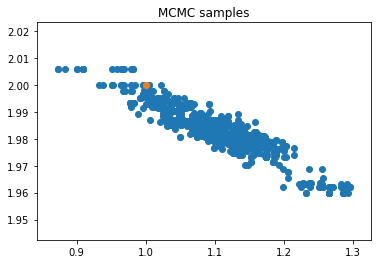

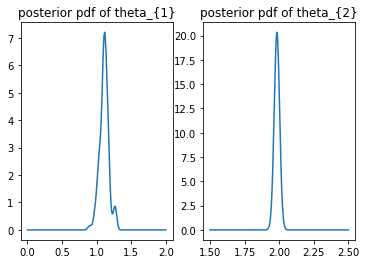

In [9]:
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(1.0, 2.0, label='true value')
plt.title('MCMC samples')
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(0, 2, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,0].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[0].plot(domain, np.exp(log_dens))
ax[0].set_title('posterior pdf of theta_{1}')

domain = np.linspace(1.5, 2.5, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,1].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[1].plot(domain, np.exp(log_dens))
ax[1].set_title('posterior pdf of theta_{2}')

plt.show()